# Header1

In [1]:
%load_ext autoreload
%autoreload 2

## data_setup.py (download_data, walk_through_dir, create_dataloaders)

In [2]:
%%writefile MakeModular/data_setup.py
"""
Contains functionality for creating Pytorch Dataloaders for
image classification data.
"""
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import requests
import zipfile
from pathlib import Path


NUM_WORKERS = os.cpu_count()

# setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

def download_data():
    """
    if data is not exists then pizza steak sushi zip file will be downloaded
    and unzipped into data_path
    Args:
        data_path (str or pathlib.Path): path location of data
    """
    
    # if the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"{image_path} directory exists.")
    else:
        print(f"Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # download pizza, steak, sushi data
        with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
            request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
            print("Downloading pizza, steak, sushi data...")
            f.write(request.content)
    
        # unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
            print("Unzipping pizza, steak, sushi data...")
            zip_ref.extractall(image_path)
    
    walk_through_dir(image_path)


def walk_through_dir(dir_path):
    """
    walks through dir_path returning its contents.
    Args:
        dir_path (str or pathlib.Path): target directory
    Returns:
        a print out of:
            number of subdirectories in dir_path
            number of images (files) in each subdirectory
            name of each subdirectory
    """
    # current_dir, child_dirs, child_files(leafs)
    for current_node, child_nodes, files in os.walk(dir_path):
        print(f"There are {len(child_nodes)} directories and {len(files)} images in '{current_node}' .")

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=None,
    pin_memory: bool=False
):
    """
    Creates training and testing DataLoaders.

    Takes train and test data directory path and creates 
    Pytorch Datasets and DataLoader objects.

    Args:
        train_dir: Path to training data directory.
        test_dir: Path to testing data directory.
        transform: torchvision transforms to perform training and testing data.
        batch_size: Number of samples per batch in dataloader object
        num_workers: Number of worker (process) for dataloader object
    
    Returns:
        A tuple of (train_dataloader, test_dataloader, class_names).
        Class names are a list of the target classes.
    
    """
    # Dataset object are created by ImageFolder dataset class (for Image Classification Format)
    train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)
    
    # Get class names
    class_names = train_dataset.classes

    if num_workers is not None:
        # train and test dataloader are created (shuffle is not necessary for testing)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                                      shuffle=True, num_workers=num_workers, pin_memory=True)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                                 shuffle=False, num_workers=num_workers, pin_memory=True)
    else:
        # train and test dataloader are created (shuffle is not necessary for testing)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                                      shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                                     shuffle=False)
    
    
    return train_dataloader, test_dataloader, class_names

Overwriting MakeModular/data_setup.py


## model_builder.py (TinyVGG, LargeVGG)

In [3]:
%%writefile MakeModular/model_builder.py
"""
Contains Pytorch model code to instantiate a TinyVGG model.
"""
import torch
from torch import nn

class TinyVGG(nn.Module):
    """
    Creates the TinyVGG architecture

    Replicates the TinyVGG architecture from the CNN explainer website in
    Pytorch. See the original architecutre here: https://poloclub.github.io/cnn-explainer/

    Args(consturcture):
        input_shape: An integer indicating number of input channels.
        hidden_units: An integer indicating number of hidden units between layers
        output_shape: An integer indicating number of output units.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classfier = nn.Sequential(
            nn.Flatten(),
            # in_features shape derived from error message by trying model with 
            # trial-garbage-experimental tensor
            nn.Linear(in_features=hidden_units*13*13,
                     out_features=output_shape)
        )
    def forward(self, x: torch.Tensor):
        # for leveraging operator fusion optimization
        return self.classfier(self.conv_block_2(self.conv_block_1(x))) 
        #x = self.conv_block_1(x)
        #x = self.conv_block_2(x)
        #x = self.classfier(x)
        #return x
class LargeVGG(nn.Module):
    """
    Creates the LargeVGG architecture

    Replicates the TinyVGG architecture from the CNN explainer website in
    Pytorch. See the original architecutre here: https://poloclub.github.io/cnn-explainer/

    Args(consturcture):
        input_shape: An integer indicating number of input channels.
        hidden_units: An integer indicating number of hidden units between layers
        output_shape: An integer indicating number of output units.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding="same"),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units*2,
                      kernel_size=3,
                      stride=1,
                      padding="same"),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*2,
                     out_channels=hidden_units*2,
                     kernel_size=3,
                     stride=1,
                     padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*2,
                      out_channels=hidden_units*4,
                      kernel_size=3,
                      stride=1,
                      padding="same"),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*4,
                     out_channels=hidden_units*4,
                     kernel_size=3,
                     stride=1,
                     padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(hidden_units*4, hidden_units*8, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.Conv2d(hidden_units*8, hidden_units*8, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classfier = nn.Sequential(
            nn.Flatten(),
            # in_features shape derived from error message by trying model with 
            # trial-garbage-experimental tensor
            nn.Linear(in_features=1280,
                     out_features=output_shape)
        )
    def forward(self, x: torch.Tensor):
        # for leveraging operator fusion optimization
        return self.classfier(self.conv_block_4(self.conv_block_3(self.conv_block_2(self.conv_block_1(x)))))
  

Overwriting MakeModular/model_builder.py


## engine.py (train_step, test_step, train)

In [4]:
try:
    from torch.utils.tensorboard import SummaryWriter
except:
    print("Tensorboard module could not found, downloading...")
    !pip install tensorboard or pip3 install tensorboard

In [5]:
%%writefile MakeModular/engine.py
"""
Contains functions for training and testing a pytorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from torch.utils.tensorboard import SummaryWriter


## TENSORBOARD UTILITIES 
def create_writer(experiment_name: str,
                 model_name: str,
                 extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter:
    """
    Creates a torch.utils.tensorboard.writer.SummaryWriter instance saving to a specific log_dir

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra

    Where timestamp is the current date in YYYY-MM-DD__H_M format

    Args:
        experiment_name (str): name of experiment
        model_name (str): name of model
        extra (str, optional): anything extra to add to the directory. Defaults to None

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir

    Example usage:
        # Create a writer saving to "runs/2023-05-27__11:32/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                                model_name="effnetb2",
                                extra="5_epochs")
        # the above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """

    from datetime import datetime
    import os
    # this will create new dir for every diffrent hour and minute
    # timestamp = datetime.now().strftime("%Y-%m-%d__%H_%M") # returns current date in YYYY-MM-DD__H_M format
    
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD__H_M format
    if extra:
        # create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)


def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              device: torch.device,
              verbose: bool=True) -> Tuple[float, float]:
    """
    Trains a pytorch model for a single epoch.

    Turns a target pytorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step)

    Args:
        model: a pytorch mdoel to be trained.
        dataloader: a dataloader object for model to be trained on
        loss_fn: a pytorch loss function to minimize
        optimizer: a pytorch optimizer to update model
        device: a target device to computed on (e.g. "cuda" or "cpu")

    Returns:
        A tuple of training loss and training accuracy metrics.
        (train_loss, train_accuracy)
    """
    # Put model in train mode
    model.train()
    
    # setup train loss and train acc values
    train_loss, train_acc = 0, 0

    # loop through dataloader batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)
        
        # 1- Forward pass
        y_pred = model(X)
        
        # 2- Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # 3- Optmizer zero grad
        optimizer.zero_grad()
        
        # 4- Loss backward
        loss.backward()
        
        # 5- Optimizer step
        optimizer.step()

        if verbose:
            print(f"Train || batch number: {batch} || current train_loss: {loss.item():.4f}")
            
        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics (loss and acc) to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader) # len(dataloader) == # of batch for 1 epoch
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc
    
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device,
              verbose: bool=True) -> Tuple[float, float]:
    """
    Tests a pytorch model for a single epoch.

    Turns a target pytorch model to "eval" mode and then performs
    a forward pass on a testing dataset via test dataloader.

    Args:
        model: a pytorch model to be tested.
        dataloader: a dataloader object for the model to be tested on
        loss_fn: a pytorch loss function to calculate loss on the test data
        device: a target device to compute on (e.g. "cuda" or "cpu")

    Returns:
        a tuple of testing loss and testing accuracy metrics.
        (test_loss, test_accuracy)
    
    """
    # change model mode to eval(evaluation)
    model.eval()
    
    # setup test loss and acc values
    test_loss, test_acc = 0, 0
   
    # turn on inference mode context manager (autograd will not track)
    with torch.inference_mode():
        
        # loop through dataloader batches
        for batch, (X, y) in enumerate(dataloader):
           
            # send data to target device
            X, y = X.to(device), y.to(device)
            
            # 1- forward pass
            test_pred_logits = model(X)
            
            # 2- calculate and accumalate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            if verbose:
                print(f"Test || batch number: {batch} || current train_loss: {loss.item():.4f}")
            
            # calculate and accumulate accuracy
            test_pred_class = test_pred_logits.argmax(dim=1) 
            test_acc += (test_pred_class == y).sum().item()/len(test_pred_class)
            
    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
         train_dataloader: torch.utils.data.DataLoader,
         test_dataloader: torch.utils.data.DataLoader,
         optimizer: torch.optim.Optimizer,
         loss_fn: torch.nn.Module,
         epochs: int,
         device: torch.device,
         writer: torch.utils.tensorboard.writer.SummaryWriter=None) -> Dict[str, list]:
    """
    Trains and tests a pytorch model.
    passes a target pytorch models through train_step() and
    test_step() functions for a number of epochs, training and 
    testing the model in the same epoch loop

    Calculates, prints and stores evaluation metrics throughout

    Stores metrics to specified writer log_dir if present (not None)

    Args:
        model: a pytorch model to be trained and tested
        train_dataloader: a dataloader object for the model to be trained on
        test_dataloader: a dataloader object for the model to be tested on
        optimizer: a pytorch optimizer to help minimize the loss function
        loss_fn: a pytorch loss function to calculate loss on both datasets
        epocs: an integer indicating how many epochs to train for.
        device: a target device to compute on (e.g. "cuda" or "cpu")
        writer: A SummaryWriter() instance to log model results to. (Optional)
    
    Returns:
        a dictionary of trainnig and testing loss as well as training
        and testing accuracy metrics. each metric has a value in a list 
        for each epoch.
        in the form of: {train_loss: [...], 
                         train_acc: [...],
                         test_loss: [...],
                         test_acc: [...]}
         e.g. train_loss: [2.003, 1.9555, 4.6] -> train loss for 3 epochs
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": [] }
    # loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device,
                                           verbose=True)

        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device,
                                        verbose=True)

        # print out what's happening
        print(
            f"Epochs: {epoch+1} | "
            f"train_loss: {train_loss:.4f} |"
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss",  # main_tag_tag_scaler_dict.key
                               tag_scalar_dict={"train_loss": train_loss,  # Loss_train_loss
                                                "test_loss": test_loss},   # Loss_test_loss
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc, # Accuracy_train_accuracy
                                                "test_acc": test_acc},  # Accuracy_test_accuracy
                               global_step=epoch)
            # Track the PyTorch model architecture
            writer.add_graph(model=model, 
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
            
            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    return results
        
            

Overwriting MakeModular/engine.py


## utils.py (save_model, set_seeds)

In [39]:
%%writefile MakeModular/utils.py
"""
Contains various utiliy functions for pytorch model training and saving
"""

import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
              target_dir: str,
              model_name: str):
    """
    Saves a pytorch model to a target directory.

    Args:
        model: a target pytorch model to save
        target_dir: a directory for saving the model to
        mdoel_name: a filename for the saved model. Should include
                    either ".pth" or "pt" as the file extension
                    
    """
    # create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                         exist_ok=True)

    # create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth' "
    model_save_path = target_dir_path / model_name

    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(), f=model_save_path)

# set seeds
def set_seeds(seed: int=42):
    """
    Sets random seeds for torch operations.

    Args:
        seed (int, optional): random seed to set. Defaults to 42
    """
    # set the seed for general torch operations
    torch.manual_seed(seed)
    # set the seed for cuda torch operations (ops in gpu)
    torch.cuda.manual_seed(seed)

Overwriting MakeModular/utils.py


## train.py (script/executable)(main, CLI)

In [7]:
%%writefile MakeModular/train.py
"""
Trains a pytorch image classification model. This file is can be directly executed
via "python train.py". For making it flexiable with command line interface
I need to functionalize statements and call them with conveinent arguments with
argparse (for example: python train.py --learning_rate 0.003 --epochs 25 --batch_size 12 ...)
"""

import os
from multiprocessing import freeze_support
import torch
import data_setup, engine, model_builder, utils

from torchvision import transforms



def main(args):
    
    # setup hyperparameters
    NUM_EPOCHS = 1 if args.epoch is None else args.epoch
    BATCH_SIZE = 32
    HIDDEN_UNITS = 10
    LEARNING_RATE = 0.001  if args.learning_rate is None else args.learning_rate
    NUM_WORKERS = os.cpu_count()
    print("Number of cpu: ", NUM_WORKERS)
    
    data_setup.download_data()
    
    # setup directories
    train_dir = "data/pizza_steak_sushi/train"
    test_dir = "data/pizza_steak_sushi/test"
    
    # setup target device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # create transforms
    data_transforms = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ])
    
    if args.multi_processing == "True":
        print(f"multi_processing state: {args.multi_processing}")
        print("Pin memory is activated, dataloader gonna use multiple cpu's...")
        # create dataloaders with help from data_setup.py
        train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
            train_dir = train_dir,
            test_dir = test_dir,
            transform = data_transforms,
            batch_size = BATCH_SIZE,
            num_workers = NUM_WORKERS - 6,    # Dangerous code! 
            pin_memory = True
        )
    else:
        print(f"multi_processing state: {args.multi_processing}")
        print("Pin memory is not activated, dataloader gonna use one cpu...")
        # create dataloaders with help from data_setup.py
        train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
            train_dir = train_dir,
            test_dir = test_dir,
            transform = data_transforms,
            batch_size = BATCH_SIZE,
        )
    
    # create model with help from model_builder.py
    if args.model == "tiny":
        # create model with help from model_builder.py
        model = model_builder.TinyVGG(
            input_shape = 3,
            hidden_units = HIDDEN_UNITS,
            output_shape = len(class_names)
        ).to(device)
    else:
        model = model_builder.LargeVGG(
            input_shape = 3,
            hidden_units = HIDDEN_UNITS,
            output_shape = len(class_names)
        ).to(device)
        
    print(model)

    # set loss and optimizer
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # start training with help from engine.py
    engine.train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                epochs=NUM_EPOCHS,
                device=device)
    
    # save the model with help from utils.py
    utils.save_model(model=model,
                    target_dir="models",
                    model_name="MakeModular_tinyvgg_modelV0.pth")

import argparse

if __name__ == "__main__":
    freeze_support()
    #parser = argparse.ArgumentParser(description="Trains your model.")
    ## positional argument (mandatory)
    #parser.add_argument("learning_rate", type=int, help="specifies learning rate")
    ## optional argument (shorthand, longhand) (requrired true -> mandatory)
    #parser.add_argument("-e", "--epoch", type=int, help="specifies epoch number", required=True)
    #args = parser.parse_args()
    #print(args.learning_rate, args.epoch)
    
    #print(sys.argv) # when command : python train.py -> prints: ["train.py"]

    parser = argparse.ArgumentParser()
    parser.add_argument("-e", "--epoch", type=int, default=1)
    parser.add_argument("-lr", "--learning_rate", type=float, default=0.001)
    parser.add_argument("--model", type=str, required=True, default="tiny")
    parser.add_argument("--multi_processing", type=str, required=True)
    args = parser.parse_args()
    
    main(args)

    

Overwriting MakeModular/train.py


In [8]:
import matplotlib.pyplot as plt
import torch
import torchvision

from pathlib import Path

from torch import nn
from torchvision import transforms

# try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

from MakeModular import data_setup, engine

C:\Users\user\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:

# Setup path to data folder
data_path = Path("MakeModular/data/")
image_path = data_path / "pizza_steak_sushi"

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [11]:
train_dir

WindowsPath('MakeModular/data/pizza_steak_sushi/train')

In [12]:
manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [13]:
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [14]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [15]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=manual_transforms,
                                                                              batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1c264561990>,
 ['pizza', 'steak', 'sushi'])

In [16]:
model_checkpoint = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_checkpoint

EfficientNet_B0_Weights.IMAGENET1K_V1

In [17]:
auto_transforms = model_checkpoint.transforms()
auto_transforms, manual_transforms

(ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ))

In [18]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1c264561030>,
 ['pizza', 'steak', 'sushi'])

In [19]:
# OLD
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# NEW      # weight enum class == checkpoint , same concepts
model_checkpoint = torchvision.models.EfficientNet_B0_Weights.DEFAULT # returns model checkpoint 
model = torchvision.models.efficientnet_b0(weights=model_checkpoint).to(device) # returns model instance with pretrained parameters

# model # very long print

In [20]:
model_checkpoint.meta.keys()

dict_keys(['categories', 'min_size', 'recipe', 'num_params', '_metrics', '_ops', '_file_size', '_docs'])

In [21]:
model_checkpoint.meta["_metrics"]

{'ImageNet-1K': {'acc@1': 77.692, 'acc@5': 93.532}}

In [22]:
summary(model=model,
       input_size=(32, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable", "mult_adds"],
       col_width=15,
        row_settings=["var_names"]
       )

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable       Mult-Adds
EfficientNet (EfficientNet)                                  [32, 3, 224, 224] [32, 1000]      --              True            --
├─Sequential (features)                                      [32, 3, 224, 224] [32, 1280, 7, 7] --              True            --
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224] [32, 32, 112, 112] --              True            --
│    │    └─Conv2d (0)                                       [32, 3, 224, 224] [32, 32, 112, 112] 864             True            346,816,512
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112] [32, 32, 112, 112] 64              True            2,048
│    │    └─SiLU (2)                                         [32, 32, 112, 112] [32, 32, 112, 112] --              --              --
│    └─Sequential (1)                                     

In [23]:
# freeze all base layers in the "features" block of the model (the feature extractor) by setting requires_grad = False
for param in model.features.parameters():
    param.requires_grad = False

In [24]:
summary(model=model,
       input_size=(32, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable", "mult_adds"],
       col_width=15,
        row_settings=["var_names"]
       )

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable       Mult-Adds
EfficientNet (EfficientNet)                                  [32, 3, 224, 224] [32, 1000]      --              Partial         --
├─Sequential (features)                                      [32, 3, 224, 224] [32, 1280, 7, 7] --              False           --
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224] [32, 32, 112, 112] --              False           --
│    │    └─Conv2d (0)                                       [32, 3, 224, 224] [32, 32, 112, 112] (864)           False           346,816,512
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112] [32, 32, 112, 112] (64)            False           2,048
│    │    └─SiLU (2)                                         [32, 32, 112, 112] [32, 32, 112, 112] --              --              --
│    └─Sequential (1)                                     

In [25]:
next(iter(model.parameters())).device

device(type='cuda', index=0)

In [26]:
# set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# recreate the classifier layer and seed it to the target device
old_classifier = model.classifier
model.classifier = torch.nn.Sequential(
                        torch.nn.Dropout(p=0.2, inplace=True),
                        torch.nn.Linear(in_features=1280,
                                       out_features=output_shape,  # 3
                                       bias=True)
                   ).to(device)

In [27]:
old_classifier, model.classifier

(Sequential(
   (0): Dropout(p=0.2, inplace=True)
   (1): Linear(in_features=1280, out_features=1000, bias=True)
 ),
 Sequential(
   (0): Dropout(p=0.2, inplace=True)
   (1): Linear(in_features=1280, out_features=3, bias=True)
 ))

In [28]:
summary(model=model,
       input_size=(32, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable", "mult_adds"],
       col_width=15,
        row_settings=["var_names"]
       )

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable       Mult-Adds
EfficientNet (EfficientNet)                                  [32, 3, 224, 224] [32, 3]         --              Partial         --
├─Sequential (features)                                      [32, 3, 224, 224] [32, 1280, 7, 7] --              False           --
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224] [32, 32, 112, 112] --              False           --
│    │    └─Conv2d (0)                                       [32, 3, 224, 224] [32, 32, 112, 112] (864)           False           346,816,512
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112] [32, 32, 112, 112] (64)            False           2,048
│    │    └─SiLU (2)                                         [32, 32, 112, 112] [32, 32, 112, 112] --              --              --
│    └─Sequential (1)                                     

In [29]:
# define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [30]:
next(iter(train_dataloader))[0].shape, next(iter(train_dataloader))[1]  # X, y 

(torch.Size([32, 3, 224, 224]),
 tensor([2, 0, 0, 1, 1, 1, 0, 1, 2, 0, 1, 2, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 2, 2,
         1, 2, 2, 2, 2, 0, 0, 0]))

In [31]:
# set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# start the timer
from timeit import default_timer as timer
start_time = timer()

# setup training and save the results
results = engine.train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=5,
                      device=device)

# end the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Train || batch number: 0 || current train_loss: 1.1655
Train || batch number: 1 || current train_loss: 1.1707
Train || batch number: 2 || current train_loss: 1.0599
Train || batch number: 3 || current train_loss: 1.0480
Train || batch number: 4 || current train_loss: 0.9886
Train || batch number: 5 || current train_loss: 1.0224
Train || batch number: 6 || current train_loss: 0.9434
Train || batch number: 7 || current train_loss: 0.9806
Test || batch number: 0 || current train_loss: 0.8643
Test || batch number: 1 || current train_loss: 0.8025


 20%|██        | 1/5 [00:02<00:08,  2.15s/it]

Test || batch number: 2 || current train_loss: 0.9287
Epochs: 1 | train_loss: 1.0474 |train_acc: 0.4375 | test_loss: 0.8652 | test_acc: 0.7339
Train || batch number: 0 || current train_loss: 0.8986
Train || batch number: 1 || current train_loss: 0.9096
Train || batch number: 2 || current train_loss: 0.7769
Train || batch number: 3 || current train_loss: 0.8040
Train || batch number: 4 || current train_loss: 0.8221
Train || batch number: 5 || current train_loss: 0.7388
Train || batch number: 6 || current train_loss: 0.7843
Train || batch number: 7 || current train_loss: 1.1404
Test || batch number: 0 || current train_loss: 0.6937
Test || batch number: 1 || current train_loss: 0.6759


 40%|████      | 2/5 [00:04<00:06,  2.01s/it]

Test || batch number: 2 || current train_loss: 0.7890
Epochs: 2 | train_loss: 0.8593 |train_acc: 0.7188 | test_loss: 0.7195 | test_acc: 0.8769
Train || batch number: 0 || current train_loss: 0.8210
Train || batch number: 1 || current train_loss: 0.6553
Train || batch number: 2 || current train_loss: 0.6688
Train || batch number: 3 || current train_loss: 0.6967
Train || batch number: 4 || current train_loss: 0.6830
Train || batch number: 5 || current train_loss: 0.5999
Train || batch number: 6 || current train_loss: 0.6549
Train || batch number: 7 || current train_loss: 0.9526
Test || batch number: 0 || current train_loss: 0.6376


 60%|██████    | 3/5 [00:06<00:03,  1.99s/it]

Test || batch number: 1 || current train_loss: 0.5800
Test || batch number: 2 || current train_loss: 0.6230
Epochs: 3 | train_loss: 0.7165 |train_acc: 0.8047 | test_loss: 0.6135 | test_acc: 0.8854
Train || batch number: 0 || current train_loss: 0.6390
Train || batch number: 1 || current train_loss: 0.5942
Train || batch number: 2 || current train_loss: 0.5728
Train || batch number: 3 || current train_loss: 0.6046
Train || batch number: 4 || current train_loss: 0.6764
Train || batch number: 5 || current train_loss: 0.5174
Train || batch number: 6 || current train_loss: 0.5194
Train || batch number: 7 || current train_loss: 1.3030
Test || batch number: 0 || current train_loss: 0.5976


 80%|████████  | 4/5 [00:08<00:02,  2.01s/it]

Test || batch number: 1 || current train_loss: 0.5275
Test || batch number: 2 || current train_loss: 0.6452
Epochs: 4 | train_loss: 0.6784 |train_acc: 0.7695 | test_loss: 0.5901 | test_acc: 0.8759
Train || batch number: 0 || current train_loss: 0.6207
Train || batch number: 1 || current train_loss: 0.5491
Train || batch number: 2 || current train_loss: 0.5448
Train || batch number: 3 || current train_loss: 0.4443
Train || batch number: 4 || current train_loss: 0.4805
Train || batch number: 5 || current train_loss: 0.4856
Train || batch number: 6 || current train_loss: 0.5307
Train || batch number: 7 || current train_loss: 0.4490
Test || batch number: 0 || current train_loss: 0.4801


100%|██████████| 5/5 [00:10<00:00,  2.03s/it]

Test || batch number: 1 || current train_loss: 0.5637
Test || batch number: 2 || current train_loss: 0.6711
Epochs: 5 | train_loss: 0.5131 |train_acc: 0.9062 | test_loss: 0.5716 | test_acc: 0.8352
[INFO] Total training time: 10.128 seconds


In [32]:
results

{'train_loss': [1.0474083423614502,
  0.859331376850605,
  0.7165346816182137,
  0.6783533915877342,
  0.5130815654993057],
 'train_acc': [0.4375, 0.71875, 0.8046875, 0.76953125, 0.90625],
 'test_loss': [0.8651969830195109,
  0.7195343971252441,
  0.613524337609609,
  0.5900911887486776,
  0.5716209510962168],
 'test_acc': [0.7339015151515151,
  0.8768939393939394,
  0.8854166666666666,
  0.8759469696969697,
  0.8352272727272728]}

In [33]:
model_checkpoint.transforms(), auto_transforms

(ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ),
 ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ))

In [34]:
model_checkpoint.transforms(), auto_transforms

(ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ),
 ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ))

In [35]:
next(iter(model.parameters())).device

device(type='cuda', index=0)

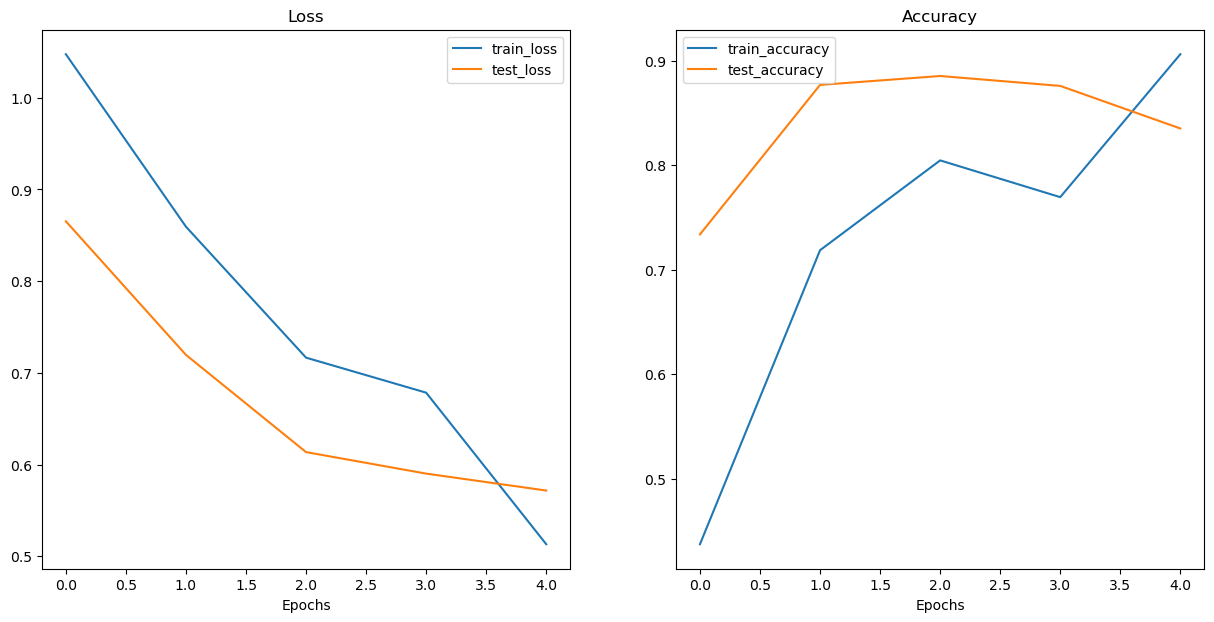

In [36]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

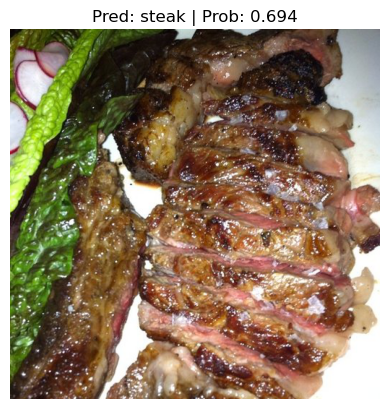

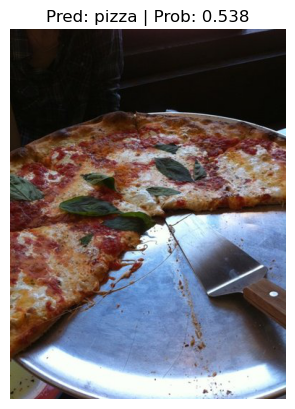

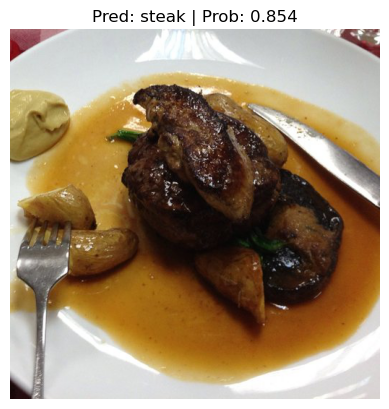

In [37]:
# get a random list of image paths from test set
import random
from helper_functions import pred_and_plot_image

num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths form test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot)  # randomly sleect "k" image paths to pred and plot


# make predictions on and plot the images
for image_path_ in test_image_path_sample:
    pred_and_plot_image(model=model,
                        device=device,
                       image_path=image_path_,
                       class_names=class_names,
                       # transform=auto_transforms
                       image_size=(224, 224))

# Experiment Tracking

In [38]:
# set seeds
def set_seeds(seed: int=42):
    """
    Sets random seeds for torch operations.

    Args:
        seed (int, optional): random seed to set. Defaults to 42
    """
    # set the seed for general torch operations
    torch.manual_seed(seed)
    # set the seed for cuda torch operations (ops in gpu)
    torch.cuda.manual_seed(seed)

In [39]:
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1c264561030>,
 ['pizza', 'steak', 'sushi'])

In [40]:
manual_transforms, auto_transforms

(Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ),
 ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ))

In [41]:
set_seeds(42)

In [42]:
from MakeModular.engine import train
results = train(model=model,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               optimizer=optimizer,
               loss_fn=loss_fn,
               epochs=5,
               device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Train || batch number: 0 || current train_loss: 0.4527
Train || batch number: 1 || current train_loss: 0.4070
Train || batch number: 2 || current train_loss: 0.3660
Train || batch number: 3 || current train_loss: 0.4413
Train || batch number: 4 || current train_loss: 0.5678
Train || batch number: 5 || current train_loss: 0.5281
Train || batch number: 6 || current train_loss: 0.4155
Train || batch number: 7 || current train_loss: 0.1971
Test || batch number: 0 || current train_loss: 0.4824


 20%|██        | 1/5 [00:02<00:08,  2.14s/it]

Test || batch number: 1 || current train_loss: 0.5034
Test || batch number: 2 || current train_loss: 0.5925
Epochs: 1 | train_loss: 0.4219 |train_acc: 0.9414 | test_loss: 0.5261 | test_acc: 0.8759
Train || batch number: 0 || current train_loss: 0.5050
Train || batch number: 1 || current train_loss: 0.4467
Train || batch number: 2 || current train_loss: 0.3169
Train || batch number: 3 || current train_loss: 0.3879
Train || batch number: 4 || current train_loss: 0.3625
Train || batch number: 5 || current train_loss: 0.3122
Train || batch number: 6 || current train_loss: 0.4510
Train || batch number: 7 || current train_loss: 0.6481
Test || batch number: 0 || current train_loss: 0.4314


 40%|████      | 2/5 [00:04<00:06,  2.11s/it]

Test || batch number: 1 || current train_loss: 0.4763
Test || batch number: 2 || current train_loss: 0.5834
Epochs: 2 | train_loss: 0.4288 |train_acc: 0.8867 | test_loss: 0.4971 | test_acc: 0.8561
Train || batch number: 0 || current train_loss: 0.4821
Train || batch number: 1 || current train_loss: 0.3319
Train || batch number: 2 || current train_loss: 0.3762
Train || batch number: 3 || current train_loss: 0.4027
Train || batch number: 4 || current train_loss: 0.3762
Train || batch number: 5 || current train_loss: 0.2887
Train || batch number: 6 || current train_loss: 0.3790
Train || batch number: 7 || current train_loss: 0.4899
Test || batch number: 0 || current train_loss: 0.4298


 60%|██████    | 3/5 [00:06<00:04,  2.14s/it]

Test || batch number: 1 || current train_loss: 0.4423
Test || batch number: 2 || current train_loss: 0.5438
Epochs: 3 | train_loss: 0.3908 |train_acc: 0.9531 | test_loss: 0.4720 | test_acc: 0.7945
Train || batch number: 0 || current train_loss: 0.3813
Train || batch number: 1 || current train_loss: 0.3074
Train || batch number: 2 || current train_loss: 0.3270
Train || batch number: 3 || current train_loss: 0.3727
Train || batch number: 4 || current train_loss: 0.4379
Train || batch number: 5 || current train_loss: 0.3022
Train || batch number: 6 || current train_loss: 0.3202
Train || batch number: 7 || current train_loss: 0.9802
Test || batch number: 0 || current train_loss: 0.4257


 80%|████████  | 4/5 [00:08<00:02,  2.13s/it]

Test || batch number: 1 || current train_loss: 0.4138
Test || batch number: 2 || current train_loss: 0.5326
Epochs: 4 | train_loss: 0.4286 |train_acc: 0.8867 | test_loss: 0.4574 | test_acc: 0.8456
Train || batch number: 0 || current train_loss: 0.4201
Train || batch number: 1 || current train_loss: 0.3404
Train || batch number: 2 || current train_loss: 0.3450
Train || batch number: 3 || current train_loss: 0.2539
Train || batch number: 4 || current train_loss: 0.2850
Train || batch number: 5 || current train_loss: 0.2921
Train || batch number: 6 || current train_loss: 0.3656
Train || batch number: 7 || current train_loss: 0.1977
Test || batch number: 0 || current train_loss: 0.3577


100%|██████████| 5/5 [00:10<00:00,  2.14s/it]

Test || batch number: 1 || current train_loss: 0.4452
Test || batch number: 2 || current train_loss: 0.5613
Epochs: 5 | train_loss: 0.3125 |train_acc: 0.9531 | test_loss: 0.4547 | test_acc: 0.8362


In [43]:
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Train || batch number: 0 || current train_loss: 0.2972
Train || batch number: 1 || current train_loss: 0.3373
Train || batch number: 2 || current train_loss: 0.4417
Train || batch number: 3 || current train_loss: 0.3402
Train || batch number: 4 || current train_loss: 0.3556
Train || batch number: 5 || current train_loss: 0.2655
Train || batch number: 6 || current train_loss: 0.3177
Train || batch number: 7 || current train_loss: 0.6504
Test || batch number: 0 || current train_loss: 0.3424


 20%|██        | 1/5 [00:02<00:08,  2.17s/it]

Test || batch number: 1 || current train_loss: 0.4408
Test || batch number: 2 || current train_loss: 0.5697
Epochs: 1 | train_loss: 0.3757 |train_acc: 0.8711 | test_loss: 0.4510 | test_acc: 0.8258
Train || batch number: 0 || current train_loss: 0.2932
Train || batch number: 1 || current train_loss: 0.2961
Train || batch number: 2 || current train_loss: 0.3055
Train || batch number: 3 || current train_loss: 0.3088
Train || batch number: 4 || current train_loss: 0.3479
Train || batch number: 5 || current train_loss: 0.2584
Train || batch number: 6 || current train_loss: 0.3317
Train || batch number: 7 || current train_loss: 0.9862
Test || batch number: 0 || current train_loss: 0.3781


 40%|████      | 2/5 [00:04<00:06,  2.11s/it]

Test || batch number: 1 || current train_loss: 0.3841
Test || batch number: 2 || current train_loss: 0.5013
Epochs: 2 | train_loss: 0.3910 |train_acc: 0.9023 | test_loss: 0.4212 | test_acc: 0.8561
Train || batch number: 0 || current train_loss: 0.2910
Train || batch number: 1 || current train_loss: 0.2457
Train || batch number: 2 || current train_loss: 0.2891
Train || batch number: 3 || current train_loss: 0.3912
Train || batch number: 4 || current train_loss: 0.2778
Train || batch number: 5 || current train_loss: 0.2495
Train || batch number: 6 || current train_loss: 0.3243
Train || batch number: 7 || current train_loss: 0.5323
Test || batch number: 0 || current train_loss: 0.3635


 60%|██████    | 3/5 [00:06<00:04,  2.16s/it]

Test || batch number: 1 || current train_loss: 0.3847
Test || batch number: 2 || current train_loss: 0.5198
Epochs: 3 | train_loss: 0.3251 |train_acc: 0.8828 | test_loss: 0.4226 | test_acc: 0.8561
Train || batch number: 0 || current train_loss: 0.2584
Train || batch number: 1 || current train_loss: 0.2862
Train || batch number: 2 || current train_loss: 0.3141
Train || batch number: 3 || current train_loss: 0.2225
Train || batch number: 4 || current train_loss: 0.3010
Train || batch number: 5 || current train_loss: 0.2521
Train || batch number: 6 || current train_loss: 0.2507
Train || batch number: 7 || current train_loss: 0.6665
Test || batch number: 0 || current train_loss: 0.3273


 80%|████████  | 4/5 [00:08<00:02,  2.16s/it]

Test || batch number: 1 || current train_loss: 0.3913
Test || batch number: 2 || current train_loss: 0.5289
Epochs: 4 | train_loss: 0.3189 |train_acc: 0.8984 | test_loss: 0.4158 | test_acc: 0.8665
Train || batch number: 0 || current train_loss: 0.2713
Train || batch number: 1 || current train_loss: 0.2146
Train || batch number: 2 || current train_loss: 0.2502
Train || batch number: 3 || current train_loss: 0.2360
Train || batch number: 4 || current train_loss: 0.2862
Train || batch number: 5 || current train_loss: 0.3253
Train || batch number: 6 || current train_loss: 0.2906
Train || batch number: 7 || current train_loss: 1.2883
Test || batch number: 0 || current train_loss: 0.3638
Test || batch number: 1 || current train_loss: 0.3543


100%|██████████| 5/5 [00:10<00:00,  2.17s/it]

Test || batch number: 2 || current train_loss: 0.5089
Epochs: 5 | train_loss: 0.3953 |train_acc: 0.8398 | test_loss: 0.4090 | test_acc: 0.8561


In [44]:
results

{'train_loss': [0.3757108822464943,
  0.3909847140312195,
  0.32510652765631676,
  0.3189367949962616,
  0.39532231725752354],
 'train_acc': [0.87109375, 0.90234375, 0.8828125, 0.8984375, 0.83984375],
 'test_loss': [0.4509703616301219,
  0.4211722215016683,
  0.4226451913515727,
  0.41580483317375183,
  0.4090009232362111],
 'test_acc': [0.8257575757575758,
  0.8560606060606061,
  0.8560606060606061,
  0.8664772727272728,
  0.8560606060606061]}

In [45]:
%load_ext tensorboard

In [46]:
%tensorboard --logdir runs

In [47]:
from helper_functions import download_data

In [48]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is 04E0-AD4F

 Directory of C:\Users\user\Dersler\Make Modular

07.01.2024  17:03    <DIR>          .
07.01.2024  17:03    <DIR>          ..
06.01.2024  20:10    <DIR>          .ipynb_checkpoints
07.01.2024  16:38    <DIR>          data
07.01.2024  17:00             8.746 helper_functions.py
06.01.2024  19:26    <DIR>          MakeModular
07.01.2024  17:03         2.268.725 MakeModular.ipynb
07.01.2024  15:38    <DIR>          models
07.01.2024  17:03    <DIR>          runs
07.01.2024  17:01    <DIR>          __pycache__
               2 File(s)      2.277.471 bytes
               8 Dir(s)  63.422.218.240 bytes free


In [49]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] MakeModular\data\pizza_steak_sushi directory exists, skipping download.
[INFO] MakeModular\data\pizza_steak_sushi_20_percent directory exists, skipping download.


In [50]:
data_10_percent_path, data_20_percent_path

(WindowsPath('MakeModular/data/pizza_steak_sushi'),
 WindowsPath('MakeModular/data/pizza_steak_sushi_20_percent'))

In [51]:
# setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: MakeModular\data\pizza_steak_sushi\train
Training directory 20%: MakeModular\data\pizza_steak_sushi_20_percent\train
Testing directory: MakeModular\data\pizza_steak_sushi\test


In [52]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset 
])

In [53]:
manual_transforms, auto_transforms, simple_transform  # 3 of them are same

(Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ),
 ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ))

In [54]:
BATCH_SIZE = 32

In [55]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                          test_dir=test_dir, 
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE
                                                                                          )
                                                                                      
# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE
                                                                                          )

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(test_dataloader)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 3 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


In [56]:
import torchvision
from torchinfo import summary

# 1. Create an instance of EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" means best available weights
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# # 2. Get a summary of standard EffNetB2 from torchvision.models (uncomment for full output)
# summary(model=effnetb2, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# ) 

# 3. Get the number of in_features of the EfficientNetB2 classifier layer
print(f"Number of in_features to final layer of EfficientNetB2: {effnetb2.classifier.state_dict()['1.weight'].shape[1]}")

Number of in_features to final layer of EfficientNetB2: 1408


In [57]:
# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [58]:
effnetb0 = create_effnetb0() 

# # Get an output summary of the layers in our EffNetB0 feature extractor model (uncomment to view full output)
# summary(model=effnetb0, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# ) 

[INFO] Created new effnetb0 model.


In [59]:
effnetb2 = create_effnetb2()

# Get an output summary of the layers in our EffNetB2 feature extractor model (uncomment to view full output)
# summary(model=effnetb2, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

[INFO] Created new effnetb2 model.


In [60]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [61]:
for dataloader_name, train_dataloader in train_dataloaders.items():
    print(dataloader_name)
    print(train_dataloader)

data_10_percent
data_20_percent


In [62]:
%%time
from MakeModular.utils import save_model
from MakeModular.engine import train, create_writer

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            if model_name == "effnetb0":
                model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"experiment_{experiment_number}_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2024-01-07\data_10_percent\effnetb0\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Train || batch number: 0 || current train_loss: 1.1305
Train || batch number: 1 || current train_loss: 1.1566
Train || batch number: 2 || current train_loss: 1.0738
Train || batch number: 3 || current train_loss: 1.0090
Train || batch number: 4 || current train_loss: 0.9925
Train || batch number: 5 || current train_loss: 1.0137
Train || batch number: 6 || current train_loss: 1.0156
Train || batch number: 7 || current train_loss: 1.2986
Test || batch number: 0 || current train_loss: 0.8370
Test || batch number: 1 || current train_loss: 0.8519
Test || batch number: 2 || current train_loss: 1.0643
Epochs: 1 | train_loss: 1.0863 |train_acc: 0.4102 | test_loss: 0.9177 | test_acc: 0.5199


 20%|██        | 1/5 [00:03<00:14,  3.71s/it]

Train || batch number: 0 || current train_loss: 0.8524
Train || batch number: 1 || current train_loss: 0.8408
Train || batch number: 2 || current train_loss: 0.8143
Train || batch number: 3 || current train_loss: 0.8889
Train || batch number: 4 || current train_loss: 0.8691
Train || batch number: 5 || current train_loss: 0.9072
Train || batch number: 6 || current train_loss: 0.8257
Train || batch number: 7 || current train_loss: 1.0116
Test || batch number: 0 || current train_loss: 0.8544
Test || batch number: 1 || current train_loss: 0.5893
Test || batch number: 2 || current train_loss: 0.6515
Epochs: 2 | train_loss: 0.8762 |train_acc: 0.6406 | test_loss: 0.6984 | test_acc: 0.8551


 40%|████      | 2/5 [00:07<00:10,  3.61s/it]

Train || batch number: 0 || current train_loss: 0.6903
Train || batch number: 1 || current train_loss: 0.7442
Train || batch number: 2 || current train_loss: 0.7341
Train || batch number: 3 || current train_loss: 0.6915
Train || batch number: 4 || current train_loss: 0.8009
Train || batch number: 5 || current train_loss: 0.7111
Train || batch number: 6 || current train_loss: 0.6744
Train || batch number: 7 || current train_loss: 0.9078
Test || batch number: 0 || current train_loss: 0.6516
Test || batch number: 1 || current train_loss: 0.6011
Test || batch number: 2 || current train_loss: 0.7294
Epochs: 3 | train_loss: 0.7443 |train_acc: 0.8438 | test_loss: 0.6607 | test_acc: 0.9072


 60%|██████    | 3/5 [00:10<00:06,  3.47s/it]

Train || batch number: 0 || current train_loss: 0.6097
Train || batch number: 1 || current train_loss: 0.6414
Train || batch number: 2 || current train_loss: 0.6194
Train || batch number: 3 || current train_loss: 0.6666
Train || batch number: 4 || current train_loss: 0.6122
Train || batch number: 5 || current train_loss: 0.5810
Train || batch number: 6 || current train_loss: 0.6251
Train || batch number: 7 || current train_loss: 1.0927
Test || batch number: 0 || current train_loss: 0.5785
Test || batch number: 1 || current train_loss: 0.5777
Test || batch number: 2 || current train_loss: 0.7529
Epochs: 4 | train_loss: 0.6810 |train_acc: 0.8203 | test_loss: 0.6364 | test_acc: 0.9072


 80%|████████  | 4/5 [00:14<00:03,  3.57s/it]

Train || batch number: 0 || current train_loss: 0.6077
Train || batch number: 1 || current train_loss: 0.5956
Train || batch number: 2 || current train_loss: 0.5582
Train || batch number: 3 || current train_loss: 0.5121
Train || batch number: 4 || current train_loss: 0.5030
Train || batch number: 5 || current train_loss: 0.5643
Train || batch number: 6 || current train_loss: 0.6114
Train || batch number: 7 || current train_loss: 0.9281
Test || batch number: 0 || current train_loss: 0.5260
Test || batch number: 1 || current train_loss: 0.5295
Test || batch number: 2 || current train_loss: 0.6354
Epochs: 5 | train_loss: 0.6101 |train_acc: 0.8398 | test_loss: 0.5636 | test_acc: 0.8968


100%|██████████| 5/5 [00:17<00:00,  3.52s/it]


[INFO] Saving model to: models\experiment_1_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2024-01-07\data_10_percent\effnetb2\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Train || batch number: 0 || current train_loss: 1.1290
Train || batch number: 1 || current train_loss: 1.0977
Train || batch number: 2 || current train_loss: 1.1087
Train || batch number: 3 || current train_loss: 1.0115
Train || batch number: 4 || current train_loss: 0.9888
Train || batch number: 5 || current train_loss: 0.9673
Train || batch number: 6 || current train_loss: 1.0149
Train || batch number: 7 || current train_loss: 1.3099
Test || batch number: 0 || current train_loss: 0.9662
Test || batch number: 1 || current train_loss: 0.8851
Test || batch number: 2 || current train_loss: 0.9409
Epochs: 1 | train_loss: 1.0785 |train_acc: 0.3906 | test_loss: 0.9307 | test_acc: 0.7320


 20%|██        | 1/5 [00:04<00:18,  4.65s/it]

Train || batch number: 0 || current train_loss: 0.8461
Train || batch number: 1 || current train_loss: 0.8800
Train || batch number: 2 || current train_loss: 0.8461
Train || batch number: 3 || current train_loss: 0.8317
Train || batch number: 4 || current train_loss: 0.8322
Train || batch number: 5 || current train_loss: 0.8736
Train || batch number: 6 || current train_loss: 0.8010
Train || batch number: 7 || current train_loss: 1.0454
Test || batch number: 0 || current train_loss: 0.7570
Test || batch number: 1 || current train_loss: 0.8314
Test || batch number: 2 || current train_loss: 0.9493
Epochs: 2 | train_loss: 0.8695 |train_acc: 0.7773 | test_loss: 0.8459 | test_acc: 0.7841


 40%|████      | 2/5 [00:09<00:13,  4.60s/it]

Train || batch number: 0 || current train_loss: 0.7570
Train || batch number: 1 || current train_loss: 0.7528
Train || batch number: 2 || current train_loss: 0.7562
Train || batch number: 3 || current train_loss: 0.7749
Train || batch number: 4 || current train_loss: 0.7936
Train || batch number: 5 || current train_loss: 0.7322
Train || batch number: 6 || current train_loss: 0.6297
Train || batch number: 7 || current train_loss: 1.2118
Test || batch number: 0 || current train_loss: 0.6757
Test || batch number: 1 || current train_loss: 0.7541
Test || batch number: 2 || current train_loss: 0.8812
Epochs: 3 | train_loss: 0.8010 |train_acc: 0.7930 | test_loss: 0.7703 | test_acc: 0.8769


 60%|██████    | 3/5 [00:13<00:09,  4.55s/it]

Train || batch number: 0 || current train_loss: 0.6499
Train || batch number: 1 || current train_loss: 0.6541
Train || batch number: 2 || current train_loss: 0.6715
Train || batch number: 3 || current train_loss: 0.6274
Train || batch number: 4 || current train_loss: 0.6411
Train || batch number: 5 || current train_loss: 0.5681
Train || batch number: 6 || current train_loss: 0.6245
Train || batch number: 7 || current train_loss: 0.9813
Test || batch number: 0 || current train_loss: 0.7070
Test || batch number: 1 || current train_loss: 0.6052
Test || batch number: 2 || current train_loss: 0.6571
Epochs: 4 | train_loss: 0.6772 |train_acc: 0.8438 | test_loss: 0.6565 | test_acc: 0.8873


 80%|████████  | 4/5 [00:18<00:04,  4.47s/it]

Train || batch number: 0 || current train_loss: 0.5462
Train || batch number: 1 || current train_loss: 0.5993
Train || batch number: 2 || current train_loss: 0.5622
Train || batch number: 3 || current train_loss: 0.5628
Train || batch number: 4 || current train_loss: 0.4794
Train || batch number: 5 || current train_loss: 0.5259
Train || batch number: 6 || current train_loss: 0.5943
Train || batch number: 7 || current train_loss: 0.4730
Test || batch number: 0 || current train_loss: 0.6355
Test || batch number: 1 || current train_loss: 0.5816
Test || batch number: 2 || current train_loss: 0.6845
Epochs: 5 | train_loss: 0.5429 |train_acc: 0.9023 | test_loss: 0.6339 | test_acc: 0.8769


100%|██████████| 5/5 [00:22<00:00,  4.51s/it]


[INFO] Saving model to: models\experiment_2_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2024-01-07\data_10_percent\effnetb0\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Train || batch number: 0 || current train_loss: 1.1305
Train || batch number: 1 || current train_loss: 1.1566
Train || batch number: 2 || current train_loss: 1.0738
Train || batch number: 3 || current train_loss: 1.0090
Train || batch number: 4 || current train_loss: 0.9925
Train || batch number: 5 || current train_loss: 1.0137
Train || batch number: 6 || current train_loss: 1.0156
Train || batch number: 7 || current train_loss: 1.2986
Test || batch number: 0 || current train_loss: 0.8370
Test || batch number: 1 || current train_loss: 0.8519
Test || batch number: 2 || current train_loss: 1.0643
Epochs: 1 | train_loss: 1.0863 |train_acc: 0.4102 | test_loss: 0.9177 | test_acc: 0.5199


 10%|█         | 1/10 [00:03<00:30,  3.38s/it]

Train || batch number: 0 || current train_loss: 0.8524
Train || batch number: 1 || current train_loss: 0.8408
Train || batch number: 2 || current train_loss: 0.8143
Train || batch number: 3 || current train_loss: 0.8889
Train || batch number: 4 || current train_loss: 0.8691
Train || batch number: 5 || current train_loss: 0.9072
Train || batch number: 6 || current train_loss: 0.8257
Train || batch number: 7 || current train_loss: 1.0116
Test || batch number: 0 || current train_loss: 0.8544
Test || batch number: 1 || current train_loss: 0.5893
Test || batch number: 2 || current train_loss: 0.6515
Epochs: 2 | train_loss: 0.8762 |train_acc: 0.6406 | test_loss: 0.6984 | test_acc: 0.8551


 20%|██        | 2/10 [00:06<00:27,  3.44s/it]

Train || batch number: 0 || current train_loss: 0.6903
Train || batch number: 1 || current train_loss: 0.7442
Train || batch number: 2 || current train_loss: 0.7341
Train || batch number: 3 || current train_loss: 0.6915
Train || batch number: 4 || current train_loss: 0.8009
Train || batch number: 5 || current train_loss: 0.7111
Train || batch number: 6 || current train_loss: 0.6744
Train || batch number: 7 || current train_loss: 0.9078
Test || batch number: 0 || current train_loss: 0.6516
Test || batch number: 1 || current train_loss: 0.6011
Test || batch number: 2 || current train_loss: 0.7294
Epochs: 3 | train_loss: 0.7443 |train_acc: 0.8438 | test_loss: 0.6607 | test_acc: 0.9072


 30%|███       | 3/10 [00:10<00:24,  3.45s/it]

Train || batch number: 0 || current train_loss: 0.6097
Train || batch number: 1 || current train_loss: 0.6414
Train || batch number: 2 || current train_loss: 0.6194
Train || batch number: 3 || current train_loss: 0.6666
Train || batch number: 4 || current train_loss: 0.6122
Train || batch number: 5 || current train_loss: 0.5810
Train || batch number: 6 || current train_loss: 0.6251
Train || batch number: 7 || current train_loss: 1.0927
Test || batch number: 0 || current train_loss: 0.5785
Test || batch number: 1 || current train_loss: 0.5777
Test || batch number: 2 || current train_loss: 0.7529
Epochs: 4 | train_loss: 0.6810 |train_acc: 0.8203 | test_loss: 0.6364 | test_acc: 0.9072


 40%|████      | 4/10 [00:14<00:21,  3.63s/it]

Train || batch number: 0 || current train_loss: 0.6077
Train || batch number: 1 || current train_loss: 0.5956
Train || batch number: 2 || current train_loss: 0.5582
Train || batch number: 3 || current train_loss: 0.5121
Train || batch number: 4 || current train_loss: 0.5030
Train || batch number: 5 || current train_loss: 0.5643
Train || batch number: 6 || current train_loss: 0.6114
Train || batch number: 7 || current train_loss: 0.9281
Test || batch number: 0 || current train_loss: 0.5260
Test || batch number: 1 || current train_loss: 0.5295
Test || batch number: 2 || current train_loss: 0.6354
Epochs: 5 | train_loss: 0.6101 |train_acc: 0.8398 | test_loss: 0.5636 | test_acc: 0.8968


 50%|█████     | 5/10 [00:17<00:18,  3.62s/it]

Train || batch number: 0 || current train_loss: 0.5128
Train || batch number: 1 || current train_loss: 0.4851
Train || batch number: 2 || current train_loss: 0.6220
Train || batch number: 3 || current train_loss: 0.5153
Train || batch number: 4 || current train_loss: 0.4474
Train || batch number: 5 || current train_loss: 0.3949
Train || batch number: 6 || current train_loss: 0.4668
Train || batch number: 7 || current train_loss: 0.7436
Test || batch number: 0 || current train_loss: 0.4330
Test || batch number: 1 || current train_loss: 0.5401
Test || batch number: 2 || current train_loss: 0.6295
Epochs: 6 | train_loss: 0.5235 |train_acc: 0.8555 | test_loss: 0.5342 | test_acc: 0.8968


 60%|██████    | 6/10 [00:21<00:14,  3.62s/it]

Train || batch number: 0 || current train_loss: 0.5311
Train || batch number: 1 || current train_loss: 0.5128
Train || batch number: 2 || current train_loss: 0.4173
Train || batch number: 3 || current train_loss: 0.5101
Train || batch number: 4 || current train_loss: 0.4486
Train || batch number: 5 || current train_loss: 0.5311
Train || batch number: 6 || current train_loss: 0.4220
Train || batch number: 7 || current train_loss: 0.4672
Test || batch number: 0 || current train_loss: 0.4445
Test || batch number: 1 || current train_loss: 0.4747
Test || batch number: 2 || current train_loss: 0.5500
Epochs: 7 | train_loss: 0.4800 |train_acc: 0.9180 | test_loss: 0.4897 | test_acc: 0.8968


 70%|███████   | 7/10 [00:24<00:10,  3.57s/it]

Train || batch number: 0 || current train_loss: 0.5158
Train || batch number: 1 || current train_loss: 0.4038
Train || batch number: 2 || current train_loss: 0.4712
Train || batch number: 3 || current train_loss: 0.4394
Train || batch number: 4 || current train_loss: 0.3389
Train || batch number: 5 || current train_loss: 0.3999
Train || batch number: 6 || current train_loss: 0.3828
Train || batch number: 7 || current train_loss: 0.9828
Test || batch number: 0 || current train_loss: 0.4468
Test || batch number: 1 || current train_loss: 0.4131
Test || batch number: 2 || current train_loss: 0.5345
Epochs: 8 | train_loss: 0.4918 |train_acc: 0.8711 | test_loss: 0.4648 | test_acc: 0.9176


 80%|████████  | 8/10 [00:28<00:07,  3.70s/it]

Train || batch number: 0 || current train_loss: 0.4165
Train || batch number: 1 || current train_loss: 0.4144
Train || batch number: 2 || current train_loss: 0.3294
Train || batch number: 3 || current train_loss: 0.4275
Train || batch number: 4 || current train_loss: 0.4608
Train || batch number: 5 || current train_loss: 0.4055
Train || batch number: 6 || current train_loss: 0.3345
Train || batch number: 7 || current train_loss: 0.5331
Test || batch number: 0 || current train_loss: 0.3923
Test || batch number: 1 || current train_loss: 0.4223
Test || batch number: 2 || current train_loss: 0.5599
Epochs: 9 | train_loss: 0.4152 |train_acc: 0.9414 | test_loss: 0.4582 | test_acc: 0.9280


 90%|█████████ | 9/10 [00:32<00:03,  3.67s/it]

Train || batch number: 0 || current train_loss: 0.3855
Train || batch number: 1 || current train_loss: 0.3950
Train || batch number: 2 || current train_loss: 0.4263
Train || batch number: 3 || current train_loss: 0.3404
Train || batch number: 4 || current train_loss: 0.3258
Train || batch number: 5 || current train_loss: 0.3905
Train || batch number: 6 || current train_loss: 0.4368
Train || batch number: 7 || current train_loss: 1.2521
Test || batch number: 0 || current train_loss: 0.3549
Test || batch number: 1 || current train_loss: 0.4170
Test || batch number: 2 || current train_loss: 0.5279
Epochs: 10 | train_loss: 0.4940 |train_acc: 0.8086 | test_loss: 0.4333 | test_acc: 0.9384


100%|██████████| 10/10 [00:36<00:00,  3.61s/it]


[INFO] Saving model to: models\experiment_3_effnetb0_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2024-01-07\data_10_percent\effnetb2\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Train || batch number: 0 || current train_loss: 1.1290
Train || batch number: 1 || current train_loss: 1.0977
Train || batch number: 2 || current train_loss: 1.1087
Train || batch number: 3 || current train_loss: 1.0115
Train || batch number: 4 || current train_loss: 0.9888
Train || batch number: 5 || current train_loss: 0.9673
Train || batch number: 6 || current train_loss: 1.0149
Train || batch number: 7 || current train_loss: 1.3099
Test || batch number: 0 || current train_loss: 0.9662
Test || batch number: 1 || current train_loss: 0.8851
Test || batch number: 2 || current train_loss: 0.9409
Epochs: 1 | train_loss: 1.0785 |train_acc: 0.3906 | test_loss: 0.9307 | test_acc: 0.7320


 10%|█         | 1/10 [00:04<00:42,  4.67s/it]

Train || batch number: 0 || current train_loss: 0.8461
Train || batch number: 1 || current train_loss: 0.8800
Train || batch number: 2 || current train_loss: 0.8461
Train || batch number: 3 || current train_loss: 0.8317
Train || batch number: 4 || current train_loss: 0.8322
Train || batch number: 5 || current train_loss: 0.8736
Train || batch number: 6 || current train_loss: 0.8010
Train || batch number: 7 || current train_loss: 1.0454
Test || batch number: 0 || current train_loss: 0.7570
Test || batch number: 1 || current train_loss: 0.8314
Test || batch number: 2 || current train_loss: 0.9493
Epochs: 2 | train_loss: 0.8695 |train_acc: 0.7773 | test_loss: 0.8459 | test_acc: 0.7841


 20%|██        | 2/10 [00:09<00:36,  4.61s/it]

Train || batch number: 0 || current train_loss: 0.7570
Train || batch number: 1 || current train_loss: 0.7528
Train || batch number: 2 || current train_loss: 0.7562
Train || batch number: 3 || current train_loss: 0.7749
Train || batch number: 4 || current train_loss: 0.7936
Train || batch number: 5 || current train_loss: 0.7322
Train || batch number: 6 || current train_loss: 0.6297
Train || batch number: 7 || current train_loss: 1.2118
Test || batch number: 0 || current train_loss: 0.6757
Test || batch number: 1 || current train_loss: 0.7541
Test || batch number: 2 || current train_loss: 0.8812
Epochs: 3 | train_loss: 0.8010 |train_acc: 0.7930 | test_loss: 0.7703 | test_acc: 0.8769


 30%|███       | 3/10 [00:14<00:32,  4.70s/it]

Train || batch number: 0 || current train_loss: 0.6499
Train || batch number: 1 || current train_loss: 0.6541
Train || batch number: 2 || current train_loss: 0.6715
Train || batch number: 3 || current train_loss: 0.6274
Train || batch number: 4 || current train_loss: 0.6411
Train || batch number: 5 || current train_loss: 0.5681
Train || batch number: 6 || current train_loss: 0.6245
Train || batch number: 7 || current train_loss: 0.9813
Test || batch number: 0 || current train_loss: 0.7070
Test || batch number: 1 || current train_loss: 0.6052
Test || batch number: 2 || current train_loss: 0.6571
Epochs: 4 | train_loss: 0.6772 |train_acc: 0.8438 | test_loss: 0.6565 | test_acc: 0.8873


 40%|████      | 4/10 [00:18<00:27,  4.50s/it]

Train || batch number: 0 || current train_loss: 0.5462
Train || batch number: 1 || current train_loss: 0.5993
Train || batch number: 2 || current train_loss: 0.5622
Train || batch number: 3 || current train_loss: 0.5628
Train || batch number: 4 || current train_loss: 0.4794
Train || batch number: 5 || current train_loss: 0.5259
Train || batch number: 6 || current train_loss: 0.5943
Train || batch number: 7 || current train_loss: 0.4730
Test || batch number: 0 || current train_loss: 0.6355
Test || batch number: 1 || current train_loss: 0.5816
Test || batch number: 2 || current train_loss: 0.6845
Epochs: 5 | train_loss: 0.5429 |train_acc: 0.9023 | test_loss: 0.6339 | test_acc: 0.8769


 50%|█████     | 5/10 [00:22<00:22,  4.53s/it]

Train || batch number: 0 || current train_loss: 0.4969
Train || batch number: 1 || current train_loss: 0.5384
Train || batch number: 2 || current train_loss: 0.4632
Train || batch number: 3 || current train_loss: 0.5341
Train || batch number: 4 || current train_loss: 0.5590
Train || batch number: 5 || current train_loss: 0.5279
Train || batch number: 6 || current train_loss: 0.4730
Train || batch number: 7 || current train_loss: 1.0130
Test || batch number: 0 || current train_loss: 0.6230
Test || batch number: 1 || current train_loss: 0.5416
Test || batch number: 2 || current train_loss: 0.6907
Epochs: 6 | train_loss: 0.5757 |train_acc: 0.8398 | test_loss: 0.6185 | test_acc: 0.8561


 60%|██████    | 6/10 [00:27<00:18,  4.58s/it]

Train || batch number: 0 || current train_loss: 0.4685
Train || batch number: 1 || current train_loss: 0.4603
Train || batch number: 2 || current train_loss: 0.4805
Train || batch number: 3 || current train_loss: 0.4265
Train || batch number: 4 || current train_loss: 0.4280
Train || batch number: 5 || current train_loss: 0.4580
Train || batch number: 6 || current train_loss: 0.4922
Train || batch number: 7 || current train_loss: 0.5162
Test || batch number: 0 || current train_loss: 0.5321
Test || batch number: 1 || current train_loss: 0.5546
Test || batch number: 2 || current train_loss: 0.7357
Epochs: 7 | train_loss: 0.4662 |train_acc: 0.9219 | test_loss: 0.6075 | test_acc: 0.8873


 70%|███████   | 7/10 [00:31<00:13,  4.49s/it]

Train || batch number: 0 || current train_loss: 0.4207
Train || batch number: 1 || current train_loss: 0.4554
Train || batch number: 2 || current train_loss: 0.3546
Train || batch number: 3 || current train_loss: 0.4848
Train || batch number: 4 || current train_loss: 0.3855
Train || batch number: 5 || current train_loss: 0.4170
Train || batch number: 6 || current train_loss: 0.5073
Train || batch number: 7 || current train_loss: 0.4375
Test || batch number: 0 || current train_loss: 0.5078
Test || batch number: 1 || current train_loss: 0.5116
Test || batch number: 2 || current train_loss: 0.6339
Epochs: 8 | train_loss: 0.4329 |train_acc: 0.9336 | test_loss: 0.5511 | test_acc: 0.8977


 80%|████████  | 8/10 [00:36<00:09,  4.69s/it]

Train || batch number: 0 || current train_loss: 0.4287
Train || batch number: 1 || current train_loss: 0.4439
Train || batch number: 2 || current train_loss: 0.3437
Train || batch number: 3 || current train_loss: 0.4362
Train || batch number: 4 || current train_loss: 0.4790
Train || batch number: 5 || current train_loss: 0.3772
Train || batch number: 6 || current train_loss: 0.3485
Train || batch number: 7 || current train_loss: 0.5470
Test || batch number: 0 || current train_loss: 0.4661
Test || batch number: 1 || current train_loss: 0.4995
Test || batch number: 2 || current train_loss: 0.6000
Epochs: 9 | train_loss: 0.4255 |train_acc: 0.9375 | test_loss: 0.5219 | test_acc: 0.8873


 90%|█████████ | 9/10 [00:41<00:04,  4.67s/it]

Train || batch number: 0 || current train_loss: 0.3404
Train || batch number: 1 || current train_loss: 0.4428
Train || batch number: 2 || current train_loss: 0.3816
Train || batch number: 3 || current train_loss: 0.3704
Train || batch number: 4 || current train_loss: 0.3614
Train || batch number: 5 || current train_loss: 0.4382
Train || batch number: 6 || current train_loss: 0.3314
Train || batch number: 7 || current train_loss: 0.5540
Test || batch number: 0 || current train_loss: 0.4643
Test || batch number: 1 || current train_loss: 0.4616
Test || batch number: 2 || current train_loss: 0.5738
Epochs: 10 | train_loss: 0.4025 |train_acc: 0.9258 | test_loss: 0.4999 | test_acc: 0.9081


100%|██████████| 10/10 [00:45<00:00,  4.59s/it]


[INFO] Saving model to: models\experiment_4_effnetb2_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 5
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2024-01-07\data_20_percent\effnetb0\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Train || batch number: 0 || current train_loss: 1.0890
Train || batch number: 1 || current train_loss: 1.1298
Train || batch number: 2 || current train_loss: 1.0900
Train || batch number: 3 || current train_loss: 1.0180
Train || batch number: 4 || current train_loss: 1.0388
Train || batch number: 5 || current train_loss: 0.9734
Train || batch number: 6 || current train_loss: 0.9357
Train || batch number: 7 || current train_loss: 0.9596
Train || batch number: 8 || current train_loss: 0.9666
Train || batch number: 9 || current train_loss: 0.9293
Train || batch number: 10 || current train_loss: 0.9103
Train || batch number: 11 || current train_loss: 0.8446
Train || batch number: 12 || current train_loss: 0.9396
Train || batch number: 13 || current train_loss: 0.8510
Train || batch number: 14 || current train_loss: 0.8468
Test || batch number: 0 || current train_loss: 0.7121
Test || batch number: 1 || current train_loss: 0.6106
Test || batch number: 2 || current train_loss: 0.7659
Epochs: 

 20%|██        | 1/5 [00:04<00:19,  4.90s/it]

Train || batch number: 0 || current train_loss: 0.7807
Train || batch number: 1 || current train_loss: 0.7474
Train || batch number: 2 || current train_loss: 0.6921
Train || batch number: 3 || current train_loss: 0.7133
Train || batch number: 4 || current train_loss: 0.7155
Train || batch number: 5 || current train_loss: 0.7259
Train || batch number: 6 || current train_loss: 0.7356
Train || batch number: 7 || current train_loss: 0.6752
Train || batch number: 8 || current train_loss: 0.6757
Train || batch number: 9 || current train_loss: 0.6355
Train || batch number: 10 || current train_loss: 0.6561
Train || batch number: 11 || current train_loss: 0.6805
Train || batch number: 12 || current train_loss: 0.6851
Train || batch number: 13 || current train_loss: 0.6421
Train || batch number: 14 || current train_loss: 0.5929
Test || batch number: 0 || current train_loss: 0.5486
Test || batch number: 1 || current train_loss: 0.5051
Test || batch number: 2 || current train_loss: 0.6086
Epochs: 

 40%|████      | 2/5 [00:09<00:14,  4.96s/it]

Train || batch number: 0 || current train_loss: 0.5820
Train || batch number: 1 || current train_loss: 0.5161
Train || batch number: 2 || current train_loss: 0.5742
Train || batch number: 3 || current train_loss: 0.5032
Train || batch number: 4 || current train_loss: 0.5359
Train || batch number: 5 || current train_loss: 0.4497
Train || batch number: 6 || current train_loss: 0.5789
Train || batch number: 7 || current train_loss: 0.5355
Train || batch number: 8 || current train_loss: 0.4944
Train || batch number: 9 || current train_loss: 0.4959
Train || batch number: 10 || current train_loss: 0.5664
Train || batch number: 11 || current train_loss: 0.5187
Train || batch number: 12 || current train_loss: 0.5671
Train || batch number: 13 || current train_loss: 0.4779
Train || batch number: 14 || current train_loss: 1.0408
Test || batch number: 0 || current train_loss: 0.4424
Test || batch number: 1 || current train_loss: 0.4087
Test || batch number: 2 || current train_loss: 0.5625
Epochs: 

 60%|██████    | 3/5 [00:15<00:10,  5.04s/it]

Train || batch number: 0 || current train_loss: 0.4695
Train || batch number: 1 || current train_loss: 0.4899
Train || batch number: 2 || current train_loss: 0.5020
Train || batch number: 3 || current train_loss: 0.5630
Train || batch number: 4 || current train_loss: 0.3968
Train || batch number: 5 || current train_loss: 0.4606
Train || batch number: 6 || current train_loss: 0.5141
Train || batch number: 7 || current train_loss: 0.4463
Train || batch number: 8 || current train_loss: 0.5777
Train || batch number: 9 || current train_loss: 0.4987
Train || batch number: 10 || current train_loss: 0.3639
Train || batch number: 11 || current train_loss: 0.4268
Train || batch number: 12 || current train_loss: 0.4810
Train || batch number: 13 || current train_loss: 0.4473
Train || batch number: 14 || current train_loss: 0.5665
Test || batch number: 0 || current train_loss: 0.4177
Test || batch number: 1 || current train_loss: 0.3232
Test || batch number: 2 || current train_loss: 0.4407
Epochs: 

 80%|████████  | 4/5 [00:20<00:05,  5.04s/it]

Train || batch number: 0 || current train_loss: 0.4910
Train || batch number: 1 || current train_loss: 0.4523
Train || batch number: 2 || current train_loss: 0.3955
Train || batch number: 3 || current train_loss: 0.3834
Train || batch number: 4 || current train_loss: 0.5152
Train || batch number: 5 || current train_loss: 0.4264
Train || batch number: 6 || current train_loss: 0.4455
Train || batch number: 7 || current train_loss: 0.4377
Train || batch number: 8 || current train_loss: 0.3349
Train || batch number: 9 || current train_loss: 0.3647
Train || batch number: 10 || current train_loss: 0.4736
Train || batch number: 11 || current train_loss: 0.3854
Train || batch number: 12 || current train_loss: 0.3977
Train || batch number: 13 || current train_loss: 0.2995
Train || batch number: 14 || current train_loss: 0.8079
Test || batch number: 0 || current train_loss: 0.3270
Test || batch number: 1 || current train_loss: 0.3415
Test || batch number: 2 || current train_loss: 0.5497
Epochs: 

100%|██████████| 5/5 [00:25<00:00,  5.08s/it]


[INFO] Saving model to: models\experiment_5_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2024-01-07\data_20_percent\effnetb2\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Train || batch number: 0 || current train_loss: 1.1349
Train || batch number: 1 || current train_loss: 1.0334
Train || batch number: 2 || current train_loss: 1.1007
Train || batch number: 3 || current train_loss: 1.0960
Train || batch number: 4 || current train_loss: 1.0037
Train || batch number: 5 || current train_loss: 1.0117
Train || batch number: 6 || current train_loss: 1.0542
Train || batch number: 7 || current train_loss: 1.0500
Train || batch number: 8 || current train_loss: 0.9877
Train || batch number: 9 || current train_loss: 0.9368
Train || batch number: 10 || current train_loss: 0.9299
Train || batch number: 11 || current train_loss: 0.9264
Train || batch number: 12 || current train_loss: 0.8595
Train || batch number: 13 || current train_loss: 0.9363
Train || batch number: 14 || current train_loss: 0.7205
Test || batch number: 0 || current train_loss: 0.7825
Test || batch number: 1 || current train_loss: 0.7791
Test || batch number: 2 || current train_loss: 0.8399
Epochs: 

 20%|██        | 1/5 [00:06<00:24,  6.12s/it]

Train || batch number: 0 || current train_loss: 0.7608
Train || batch number: 1 || current train_loss: 0.8945
Train || batch number: 2 || current train_loss: 0.8542
Train || batch number: 3 || current train_loss: 0.7274
Train || batch number: 4 || current train_loss: 0.7774
Train || batch number: 5 || current train_loss: 0.8445
Train || batch number: 6 || current train_loss: 0.7400
Train || batch number: 7 || current train_loss: 0.7130
Train || batch number: 8 || current train_loss: 0.7578
Train || batch number: 9 || current train_loss: 0.6394
Train || batch number: 10 || current train_loss: 0.5512
Train || batch number: 11 || current train_loss: 0.6827
Train || batch number: 12 || current train_loss: 0.5539
Train || batch number: 13 || current train_loss: 0.6723
Train || batch number: 14 || current train_loss: 0.7877
Test || batch number: 0 || current train_loss: 0.6667
Test || batch number: 1 || current train_loss: 0.5832
Test || batch number: 2 || current train_loss: 0.7153
Epochs: 

 40%|████      | 2/5 [00:11<00:17,  5.87s/it]

Train || batch number: 0 || current train_loss: 0.5727
Train || batch number: 1 || current train_loss: 0.6365
Train || batch number: 2 || current train_loss: 0.6246
Train || batch number: 3 || current train_loss: 0.5382
Train || batch number: 4 || current train_loss: 0.5714
Train || batch number: 5 || current train_loss: 0.6951
Train || batch number: 6 || current train_loss: 0.5011
Train || batch number: 7 || current train_loss: 0.5357
Train || batch number: 8 || current train_loss: 0.5964
Train || batch number: 9 || current train_loss: 0.5995
Train || batch number: 10 || current train_loss: 0.4514
Train || batch number: 11 || current train_loss: 0.6339
Train || batch number: 12 || current train_loss: 0.4729
Train || batch number: 13 || current train_loss: 0.4822
Train || batch number: 14 || current train_loss: 1.2044
Test || batch number: 0 || current train_loss: 0.5638
Test || batch number: 1 || current train_loss: 0.4859
Test || batch number: 2 || current train_loss: 0.5653
Epochs: 

 60%|██████    | 3/5 [00:18<00:12,  6.06s/it]

Train || batch number: 0 || current train_loss: 0.4272
Train || batch number: 1 || current train_loss: 0.4892
Train || batch number: 2 || current train_loss: 0.5222
Train || batch number: 3 || current train_loss: 0.5024
Train || batch number: 4 || current train_loss: 0.4966
Train || batch number: 5 || current train_loss: 0.4764
Train || batch number: 6 || current train_loss: 0.5262
Train || batch number: 7 || current train_loss: 0.5430
Train || batch number: 8 || current train_loss: 0.5258
Train || batch number: 9 || current train_loss: 0.4452
Train || batch number: 10 || current train_loss: 0.4724
Train || batch number: 11 || current train_loss: 0.4047
Train || batch number: 12 || current train_loss: 0.5524
Train || batch number: 13 || current train_loss: 0.3973
Train || batch number: 14 || current train_loss: 0.3006
Test || batch number: 0 || current train_loss: 0.4837
Test || batch number: 1 || current train_loss: 0.4658
Test || batch number: 2 || current train_loss: 0.6867
Epochs: 

 80%|████████  | 4/5 [00:24<00:06,  6.00s/it]

Train || batch number: 0 || current train_loss: 0.5044
Train || batch number: 1 || current train_loss: 0.3741
Train || batch number: 2 || current train_loss: 0.3008
Train || batch number: 3 || current train_loss: 0.3860
Train || batch number: 4 || current train_loss: 0.3908
Train || batch number: 5 || current train_loss: 0.4522
Train || batch number: 6 || current train_loss: 0.4079
Train || batch number: 7 || current train_loss: 0.4411
Train || batch number: 8 || current train_loss: 0.5479
Train || batch number: 9 || current train_loss: 0.4180
Train || batch number: 10 || current train_loss: 0.4258
Train || batch number: 11 || current train_loss: 0.4578
Train || batch number: 12 || current train_loss: 0.3860
Train || batch number: 13 || current train_loss: 0.4523
Train || batch number: 14 || current train_loss: 0.6989
Test || batch number: 0 || current train_loss: 0.4297
Test || batch number: 1 || current train_loss: 0.3992
Test || batch number: 2 || current train_loss: 0.5952
Epochs: 

100%|██████████| 5/5 [00:29<00:00,  5.99s/it]


[INFO] Saving model to: models\experiment_6_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2024-01-07\data_20_percent\effnetb0\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Train || batch number: 0 || current train_loss: 1.0890
Train || batch number: 1 || current train_loss: 1.1298
Train || batch number: 2 || current train_loss: 1.0900
Train || batch number: 3 || current train_loss: 1.0180
Train || batch number: 4 || current train_loss: 1.0388
Train || batch number: 5 || current train_loss: 0.9734
Train || batch number: 6 || current train_loss: 0.9357
Train || batch number: 7 || current train_loss: 0.9596
Train || batch number: 8 || current train_loss: 0.9666
Train || batch number: 9 || current train_loss: 0.9293
Train || batch number: 10 || current train_loss: 0.9103
Train || batch number: 11 || current train_loss: 0.8446
Train || batch number: 12 || current train_loss: 0.9396
Train || batch number: 13 || current train_loss: 0.8510
Train || batch number: 14 || current train_loss: 0.8468
Test || batch number: 0 || current train_loss: 0.7121
Test || batch number: 1 || current train_loss: 0.6106
Test || batch number: 2 || current train_loss: 0.7659
Epochs: 

 10%|█         | 1/10 [00:05<00:45,  5.08s/it]

Train || batch number: 0 || current train_loss: 0.7807
Train || batch number: 1 || current train_loss: 0.7474
Train || batch number: 2 || current train_loss: 0.6921
Train || batch number: 3 || current train_loss: 0.7133
Train || batch number: 4 || current train_loss: 0.7155
Train || batch number: 5 || current train_loss: 0.7259
Train || batch number: 6 || current train_loss: 0.7356
Train || batch number: 7 || current train_loss: 0.6752
Train || batch number: 8 || current train_loss: 0.6757
Train || batch number: 9 || current train_loss: 0.6355
Train || batch number: 10 || current train_loss: 0.6561
Train || batch number: 11 || current train_loss: 0.6805
Train || batch number: 12 || current train_loss: 0.6851
Train || batch number: 13 || current train_loss: 0.6421
Train || batch number: 14 || current train_loss: 0.5929
Test || batch number: 0 || current train_loss: 0.5486
Test || batch number: 1 || current train_loss: 0.5051
Test || batch number: 2 || current train_loss: 0.6086
Epochs: 

 20%|██        | 2/10 [00:10<00:42,  5.28s/it]

Train || batch number: 0 || current train_loss: 0.5820
Train || batch number: 1 || current train_loss: 0.5161
Train || batch number: 2 || current train_loss: 0.5742
Train || batch number: 3 || current train_loss: 0.5032
Train || batch number: 4 || current train_loss: 0.5359
Train || batch number: 5 || current train_loss: 0.4497
Train || batch number: 6 || current train_loss: 0.5789
Train || batch number: 7 || current train_loss: 0.5355
Train || batch number: 8 || current train_loss: 0.4944
Train || batch number: 9 || current train_loss: 0.4959
Train || batch number: 10 || current train_loss: 0.5664
Train || batch number: 11 || current train_loss: 0.5187
Train || batch number: 12 || current train_loss: 0.5671
Train || batch number: 13 || current train_loss: 0.4779
Train || batch number: 14 || current train_loss: 1.0408
Test || batch number: 0 || current train_loss: 0.4424
Test || batch number: 1 || current train_loss: 0.4087
Test || batch number: 2 || current train_loss: 0.5625
Epochs: 

 30%|███       | 3/10 [00:15<00:37,  5.30s/it]

Train || batch number: 0 || current train_loss: 0.4695
Train || batch number: 1 || current train_loss: 0.4899
Train || batch number: 2 || current train_loss: 0.5020
Train || batch number: 3 || current train_loss: 0.5630
Train || batch number: 4 || current train_loss: 0.3968
Train || batch number: 5 || current train_loss: 0.4606
Train || batch number: 6 || current train_loss: 0.5141
Train || batch number: 7 || current train_loss: 0.4463
Train || batch number: 8 || current train_loss: 0.5777
Train || batch number: 9 || current train_loss: 0.4987
Train || batch number: 10 || current train_loss: 0.3639
Train || batch number: 11 || current train_loss: 0.4268
Train || batch number: 12 || current train_loss: 0.4810
Train || batch number: 13 || current train_loss: 0.4473
Train || batch number: 14 || current train_loss: 0.5665
Test || batch number: 0 || current train_loss: 0.4177
Test || batch number: 1 || current train_loss: 0.3232
Test || batch number: 2 || current train_loss: 0.4407
Epochs: 

 40%|████      | 4/10 [00:21<00:32,  5.39s/it]

Train || batch number: 0 || current train_loss: 0.4910
Train || batch number: 1 || current train_loss: 0.4523
Train || batch number: 2 || current train_loss: 0.3955
Train || batch number: 3 || current train_loss: 0.3834
Train || batch number: 4 || current train_loss: 0.5152
Train || batch number: 5 || current train_loss: 0.4264
Train || batch number: 6 || current train_loss: 0.4455
Train || batch number: 7 || current train_loss: 0.4377
Train || batch number: 8 || current train_loss: 0.3349
Train || batch number: 9 || current train_loss: 0.3647
Train || batch number: 10 || current train_loss: 0.4736
Train || batch number: 11 || current train_loss: 0.3854
Train || batch number: 12 || current train_loss: 0.3977
Train || batch number: 13 || current train_loss: 0.2995
Train || batch number: 14 || current train_loss: 0.8079
Test || batch number: 0 || current train_loss: 0.3270
Test || batch number: 1 || current train_loss: 0.3415
Test || batch number: 2 || current train_loss: 0.5497
Epochs: 

 50%|█████     | 5/10 [00:26<00:26,  5.37s/it]

Train || batch number: 0 || current train_loss: 0.2629
Train || batch number: 1 || current train_loss: 0.4112
Train || batch number: 2 || current train_loss: 0.3371
Train || batch number: 3 || current train_loss: 0.3566
Train || batch number: 4 || current train_loss: 0.5554
Train || batch number: 5 || current train_loss: 0.4271
Train || batch number: 6 || current train_loss: 0.3145
Train || batch number: 7 || current train_loss: 0.4210
Train || batch number: 8 || current train_loss: 0.3277
Train || batch number: 9 || current train_loss: 0.3429
Train || batch number: 10 || current train_loss: 0.3784
Train || batch number: 11 || current train_loss: 0.3553
Train || batch number: 12 || current train_loss: 0.3334
Train || batch number: 13 || current train_loss: 0.2597
Train || batch number: 14 || current train_loss: 0.7892
Test || batch number: 0 || current train_loss: 0.3364
Test || batch number: 1 || current train_loss: 0.2828
Test || batch number: 2 || current train_loss: 0.4297
Epochs: 

 60%|██████    | 6/10 [00:32<00:21,  5.37s/it]

Train || batch number: 0 || current train_loss: 0.3657
Train || batch number: 1 || current train_loss: 0.4748
Train || batch number: 2 || current train_loss: 0.3583
Train || batch number: 3 || current train_loss: 0.3420
Train || batch number: 4 || current train_loss: 0.2598
Train || batch number: 5 || current train_loss: 0.3687
Train || batch number: 6 || current train_loss: 0.3937
Train || batch number: 7 || current train_loss: 0.3816
Train || batch number: 8 || current train_loss: 0.3193
Train || batch number: 9 || current train_loss: 0.2566
Train || batch number: 10 || current train_loss: 0.2866
Train || batch number: 11 || current train_loss: 0.3950
Train || batch number: 12 || current train_loss: 0.2995
Train || batch number: 13 || current train_loss: 0.3448
Train || batch number: 14 || current train_loss: 0.4013
Test || batch number: 0 || current train_loss: 0.3099
Test || batch number: 1 || current train_loss: 0.2480
Test || batch number: 2 || current train_loss: 0.3938
Epochs: 

 70%|███████   | 7/10 [00:37<00:16,  5.36s/it]

Train || batch number: 0 || current train_loss: 0.2141
Train || batch number: 1 || current train_loss: 0.3160
Train || batch number: 2 || current train_loss: 0.3775
Train || batch number: 3 || current train_loss: 0.3389
Train || batch number: 4 || current train_loss: 0.2729
Train || batch number: 5 || current train_loss: 0.3501
Train || batch number: 6 || current train_loss: 0.3832
Train || batch number: 7 || current train_loss: 0.2906
Train || batch number: 8 || current train_loss: 0.2885
Train || batch number: 9 || current train_loss: 0.3268
Train || batch number: 10 || current train_loss: 0.3233
Train || batch number: 11 || current train_loss: 0.2426
Train || batch number: 12 || current train_loss: 0.3401
Train || batch number: 13 || current train_loss: 0.3330
Train || batch number: 14 || current train_loss: 0.3247
Test || batch number: 0 || current train_loss: 0.3038
Test || batch number: 1 || current train_loss: 0.2371
Test || batch number: 2 || current train_loss: 0.3873
Epochs: 

 80%|████████  | 8/10 [00:42<00:10,  5.29s/it]

Train || batch number: 0 || current train_loss: 0.2052
Train || batch number: 1 || current train_loss: 0.3104
Train || batch number: 2 || current train_loss: 0.3547
Train || batch number: 3 || current train_loss: 0.2139
Train || batch number: 4 || current train_loss: 0.4250
Train || batch number: 5 || current train_loss: 0.5229
Train || batch number: 6 || current train_loss: 0.3146
Train || batch number: 7 || current train_loss: 0.2612
Train || batch number: 8 || current train_loss: 0.2851
Train || batch number: 9 || current train_loss: 0.3920
Train || batch number: 10 || current train_loss: 0.2842
Train || batch number: 11 || current train_loss: 0.2635
Train || batch number: 12 || current train_loss: 0.2253
Train || batch number: 13 || current train_loss: 0.3536
Train || batch number: 14 || current train_loss: 1.3446
Test || batch number: 0 || current train_loss: 0.2763
Test || batch number: 1 || current train_loss: 0.2176
Test || batch number: 2 || current train_loss: 0.3708
Epochs: 

 90%|█████████ | 9/10 [00:47<00:05,  5.27s/it]

Train || batch number: 0 || current train_loss: 0.3601
Train || batch number: 1 || current train_loss: 0.3696
Train || batch number: 2 || current train_loss: 0.3398
Train || batch number: 3 || current train_loss: 0.2741
Train || batch number: 4 || current train_loss: 0.3121
Train || batch number: 5 || current train_loss: 0.2104
Train || batch number: 6 || current train_loss: 0.2845
Train || batch number: 7 || current train_loss: 0.2117
Train || batch number: 8 || current train_loss: 0.2728
Train || batch number: 9 || current train_loss: 0.2903
Train || batch number: 10 || current train_loss: 0.2066
Train || batch number: 11 || current train_loss: 0.2614
Train || batch number: 12 || current train_loss: 0.3333
Train || batch number: 13 || current train_loss: 0.2633
Train || batch number: 14 || current train_loss: 0.3094
Test || batch number: 0 || current train_loss: 0.2856
Test || batch number: 1 || current train_loss: 0.1973
Test || batch number: 2 || current train_loss: 0.3834
Epochs: 

100%|██████████| 10/10 [00:53<00:00,  5.32s/it]


[INFO] Saving model to: models\experiment_7_effnetb0_data_20_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 8
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2024-01-07\data_20_percent\effnetb2\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Train || batch number: 0 || current train_loss: 1.1349
Train || batch number: 1 || current train_loss: 1.0334
Train || batch number: 2 || current train_loss: 1.1007
Train || batch number: 3 || current train_loss: 1.0960
Train || batch number: 4 || current train_loss: 1.0037
Train || batch number: 5 || current train_loss: 1.0117
Train || batch number: 6 || current train_loss: 1.0542
Train || batch number: 7 || current train_loss: 1.0500
Train || batch number: 8 || current train_loss: 0.9877
Train || batch number: 9 || current train_loss: 0.9368
Train || batch number: 10 || current train_loss: 0.9299
Train || batch number: 11 || current train_loss: 0.9264
Train || batch number: 12 || current train_loss: 0.8595
Train || batch number: 13 || current train_loss: 0.9363
Train || batch number: 14 || current train_loss: 0.7205
Test || batch number: 0 || current train_loss: 0.7825
Test || batch number: 1 || current train_loss: 0.7791
Test || batch number: 2 || current train_loss: 0.8399
Epochs: 

 10%|█         | 1/10 [00:06<00:55,  6.12s/it]

Train || batch number: 0 || current train_loss: 0.7608
Train || batch number: 1 || current train_loss: 0.8945
Train || batch number: 2 || current train_loss: 0.8542
Train || batch number: 3 || current train_loss: 0.7274
Train || batch number: 4 || current train_loss: 0.7774
Train || batch number: 5 || current train_loss: 0.8445
Train || batch number: 6 || current train_loss: 0.7400
Train || batch number: 7 || current train_loss: 0.7130
Train || batch number: 8 || current train_loss: 0.7578
Train || batch number: 9 || current train_loss: 0.6394
Train || batch number: 10 || current train_loss: 0.5512
Train || batch number: 11 || current train_loss: 0.6827
Train || batch number: 12 || current train_loss: 0.5539
Train || batch number: 13 || current train_loss: 0.6723
Train || batch number: 14 || current train_loss: 0.7877
Test || batch number: 0 || current train_loss: 0.6667
Test || batch number: 1 || current train_loss: 0.5832
Test || batch number: 2 || current train_loss: 0.7153
Epochs: 

 20%|██        | 2/10 [00:11<00:47,  5.91s/it]

Train || batch number: 0 || current train_loss: 0.5727
Train || batch number: 1 || current train_loss: 0.6365
Train || batch number: 2 || current train_loss: 0.6246
Train || batch number: 3 || current train_loss: 0.5382
Train || batch number: 4 || current train_loss: 0.5714
Train || batch number: 5 || current train_loss: 0.6951
Train || batch number: 6 || current train_loss: 0.5011
Train || batch number: 7 || current train_loss: 0.5357
Train || batch number: 8 || current train_loss: 0.5964
Train || batch number: 9 || current train_loss: 0.5995
Train || batch number: 10 || current train_loss: 0.4514
Train || batch number: 11 || current train_loss: 0.6339
Train || batch number: 12 || current train_loss: 0.4729
Train || batch number: 13 || current train_loss: 0.4822
Train || batch number: 14 || current train_loss: 1.2044
Test || batch number: 0 || current train_loss: 0.5638
Test || batch number: 1 || current train_loss: 0.4859
Test || batch number: 2 || current train_loss: 0.5653
Epochs: 

 30%|███       | 3/10 [00:18<00:42,  6.05s/it]

Train || batch number: 0 || current train_loss: 0.4272
Train || batch number: 1 || current train_loss: 0.4892
Train || batch number: 2 || current train_loss: 0.5222
Train || batch number: 3 || current train_loss: 0.5024
Train || batch number: 4 || current train_loss: 0.4966
Train || batch number: 5 || current train_loss: 0.4764
Train || batch number: 6 || current train_loss: 0.5262
Train || batch number: 7 || current train_loss: 0.5430
Train || batch number: 8 || current train_loss: 0.5258
Train || batch number: 9 || current train_loss: 0.4452
Train || batch number: 10 || current train_loss: 0.4724
Train || batch number: 11 || current train_loss: 0.4047
Train || batch number: 12 || current train_loss: 0.5524
Train || batch number: 13 || current train_loss: 0.3973
Train || batch number: 14 || current train_loss: 0.3006
Test || batch number: 0 || current train_loss: 0.4837
Test || batch number: 1 || current train_loss: 0.4658
Test || batch number: 2 || current train_loss: 0.6867
Epochs: 

 40%|████      | 4/10 [00:24<00:36,  6.01s/it]

Train || batch number: 0 || current train_loss: 0.5044
Train || batch number: 1 || current train_loss: 0.3741
Train || batch number: 2 || current train_loss: 0.3008
Train || batch number: 3 || current train_loss: 0.3860
Train || batch number: 4 || current train_loss: 0.3908
Train || batch number: 5 || current train_loss: 0.4522
Train || batch number: 6 || current train_loss: 0.4079
Train || batch number: 7 || current train_loss: 0.4411
Train || batch number: 8 || current train_loss: 0.5479
Train || batch number: 9 || current train_loss: 0.4180
Train || batch number: 10 || current train_loss: 0.4258
Train || batch number: 11 || current train_loss: 0.4578
Train || batch number: 12 || current train_loss: 0.3860
Train || batch number: 13 || current train_loss: 0.4523
Train || batch number: 14 || current train_loss: 0.6989
Test || batch number: 0 || current train_loss: 0.4297
Test || batch number: 1 || current train_loss: 0.3992
Test || batch number: 2 || current train_loss: 0.5952
Epochs: 

 50%|█████     | 5/10 [00:30<00:30,  6.07s/it]

Train || batch number: 0 || current train_loss: 0.4774
Train || batch number: 1 || current train_loss: 0.4668
Train || batch number: 2 || current train_loss: 0.3838
Train || batch number: 3 || current train_loss: 0.4080
Train || batch number: 4 || current train_loss: 0.4000
Train || batch number: 5 || current train_loss: 0.3237
Train || batch number: 6 || current train_loss: 0.3502
Train || batch number: 7 || current train_loss: 0.4639
Train || batch number: 8 || current train_loss: 0.2733
Train || batch number: 9 || current train_loss: 0.3232
Train || batch number: 10 || current train_loss: 0.3138
Train || batch number: 11 || current train_loss: 0.4351
Train || batch number: 12 || current train_loss: 0.3744
Train || batch number: 13 || current train_loss: 0.3214
Train || batch number: 14 || current train_loss: 0.1735
Test || batch number: 0 || current train_loss: 0.4037
Test || batch number: 1 || current train_loss: 0.3970
Test || batch number: 2 || current train_loss: 0.6382
Epochs: 

 60%|██████    | 6/10 [00:36<00:24,  6.18s/it]

Train || batch number: 0 || current train_loss: 0.3687
Train || batch number: 1 || current train_loss: 0.3377
Train || batch number: 2 || current train_loss: 0.3619
Train || batch number: 3 || current train_loss: 0.3655
Train || batch number: 4 || current train_loss: 0.2814
Train || batch number: 5 || current train_loss: 0.3771
Train || batch number: 6 || current train_loss: 0.3485
Train || batch number: 7 || current train_loss: 0.2907
Train || batch number: 8 || current train_loss: 0.3562
Train || batch number: 9 || current train_loss: 0.4634
Train || batch number: 10 || current train_loss: 0.3910
Train || batch number: 11 || current train_loss: 0.3234
Train || batch number: 12 || current train_loss: 0.2685
Train || batch number: 13 || current train_loss: 0.4037
Train || batch number: 14 || current train_loss: 0.1684
Test || batch number: 0 || current train_loss: 0.4090
Test || batch number: 1 || current train_loss: 0.3333
Test || batch number: 2 || current train_loss: 0.5222
Epochs: 

 70%|███████   | 7/10 [00:42<00:18,  6.13s/it]

Train || batch number: 0 || current train_loss: 0.3418
Train || batch number: 1 || current train_loss: 0.4223
Train || batch number: 2 || current train_loss: 0.3509
Train || batch number: 3 || current train_loss: 0.2706
Train || batch number: 4 || current train_loss: 0.2401
Train || batch number: 5 || current train_loss: 0.2865
Train || batch number: 6 || current train_loss: 0.3217
Train || batch number: 7 || current train_loss: 0.4023
Train || batch number: 8 || current train_loss: 0.2954
Train || batch number: 9 || current train_loss: 0.2898
Train || batch number: 10 || current train_loss: 0.3368
Train || batch number: 11 || current train_loss: 0.3805
Train || batch number: 12 || current train_loss: 0.2936
Train || batch number: 13 || current train_loss: 0.2986
Train || batch number: 14 || current train_loss: 0.3428
Test || batch number: 0 || current train_loss: 0.3664
Test || batch number: 1 || current train_loss: 0.3398
Test || batch number: 2 || current train_loss: 0.5515
Epochs: 

 80%|████████  | 8/10 [00:48<00:12,  6.13s/it]

Train || batch number: 0 || current train_loss: 0.3331
Train || batch number: 1 || current train_loss: 0.3117
Train || batch number: 2 || current train_loss: 0.2698
Train || batch number: 3 || current train_loss: 0.2791
Train || batch number: 4 || current train_loss: 0.2595
Train || batch number: 5 || current train_loss: 0.3973
Train || batch number: 6 || current train_loss: 0.2783
Train || batch number: 7 || current train_loss: 0.3144
Train || batch number: 8 || current train_loss: 0.3369
Train || batch number: 9 || current train_loss: 0.2853
Train || batch number: 10 || current train_loss: 0.2631
Train || batch number: 11 || current train_loss: 0.2907
Train || batch number: 12 || current train_loss: 0.3443
Train || batch number: 13 || current train_loss: 0.2313
Train || batch number: 14 || current train_loss: 0.0860
Test || batch number: 0 || current train_loss: 0.3525
Test || batch number: 1 || current train_loss: 0.3166
Test || batch number: 2 || current train_loss: 0.5811
Epochs: 

 90%|█████████ | 9/10 [00:55<00:06,  6.18s/it]

Train || batch number: 0 || current train_loss: 0.2784
Train || batch number: 1 || current train_loss: 0.2507
Train || batch number: 2 || current train_loss: 0.2663
Train || batch number: 3 || current train_loss: 0.2898
Train || batch number: 4 || current train_loss: 0.4109
Train || batch number: 5 || current train_loss: 0.2672
Train || batch number: 6 || current train_loss: 0.1891
Train || batch number: 7 || current train_loss: 0.4198
Train || batch number: 8 || current train_loss: 0.2444
Train || batch number: 9 || current train_loss: 0.2634
Train || batch number: 10 || current train_loss: 0.2746
Train || batch number: 11 || current train_loss: 0.2482
Train || batch number: 12 || current train_loss: 0.2194
Train || batch number: 13 || current train_loss: 0.2388
Train || batch number: 14 || current train_loss: 1.2676
Test || batch number: 0 || current train_loss: 0.3086
Test || batch number: 1 || current train_loss: 0.3664
Test || batch number: 2 || current train_loss: 0.6553
Epochs: 

100%|██████████| 10/10 [01:01<00:00,  6.11s/it]

[INFO] Saving model to: models\experiment_8_effnetb2_data_20_percent_10_epochs.pth
--------------------------------------------------

CPU times: total: 18min 42s
Wall time: 4min 53s


In [64]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
%load_ext tensorboard
%tensorboard --logdir runs/2024-01-07

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [65]:
# Setup the best model filepath
best_model_path = "models/experiment_8_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load the saved state_dict() to)
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

In [66]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


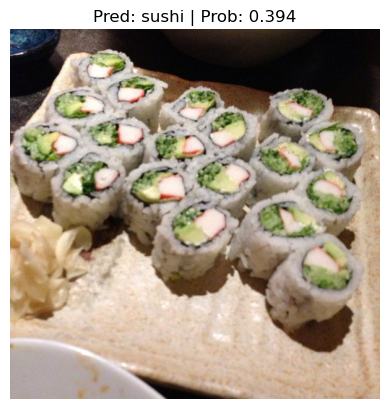

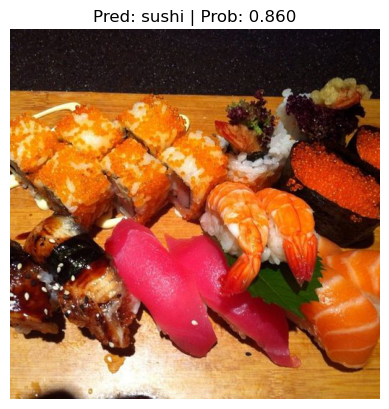

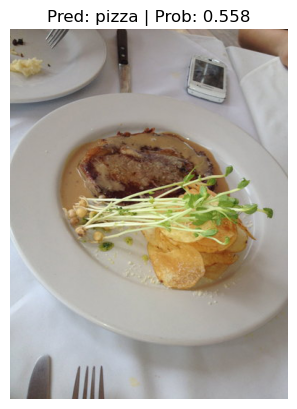

In [67]:
# Import function to make predictions on images and plot them 
# See the function previously created in section: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
from helper_functions import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

# Paper Replicating (ViT: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale)
#### Vit Base 16

In [1]:
import helper_functions
from MakeModular import data_setup, engine, model_builder, utils

C:\Users\user\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

from pathlib import Path
import matplotlib.pyplot as plt

torch version: 2.1.2+cu121
torchvision version: 0.16.2+cu121


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
image_path = Path("data/pizza_steak_sushi_20_percent/")
train_dir = image_path / "train"
test_dir = image_path / "test"
image_path, train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi_20_percent'),
 WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

In [5]:
# create image size (from table 3 in the ViT paper)
IMG_SIZE = 224

# create transform pipeline manually
manual_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor()
    ])
print(f"Manually created transforms: {manual_transform}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [6]:
# set the batch size
BATCH_SIZE = 32

# create dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transform,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x26533474370>,
 ['pizza', 'steak', 'sushi'])

In [7]:
len(train_dataloader), len(test_dataloader), len(class_names)

(15, 5, 3)

In [8]:
# get the first batch (X, y)
image_batch, label_batch = next(iter(train_dataloader))

# get a single image from the batch
image, label = image_batch[0], label_batch[0]

# view the batch shapes
image.shape, label, "batch.shape: ", image_batch.shape

(torch.Size([3, 224, 224]),
 tensor(2),
 'batch.shape: ',
 torch.Size([32, 3, 224, 224]))

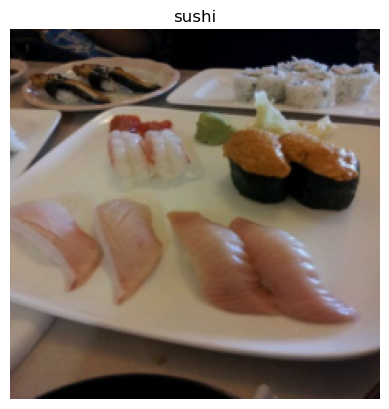

In [9]:
# plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) 
plt.title(class_names[label])
plt.axis(False);

In [10]:
height = 224 # H
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# calculate N (number of patches-sequence length)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H:{height}), width (W:{width}) and patch size (P:{patch_size})-> {number_of_patches}")

Number of patches (N) with image height (H:224), width (W:224) and patch size (P:16)-> 196


In [11]:
# Input shape (size of the single image)
embedding_layer_input_shape = (height, width, color_channels)

# output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2d image): {embedding_layer_input_shape}")
print(f"Output shape (single 2d image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2d image): (224, 224, 3)
Output shape (single 2d image flattened into patches): (196, 768)


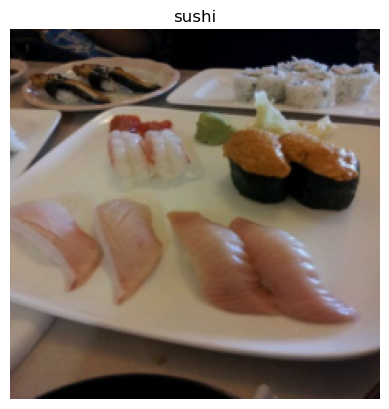

In [12]:
# view single image
plt.imshow(image.permute(1, 2, 0))  # (C, H, W) -> (H, W, C)
plt.title(class_names[label])
plt.axis(False);

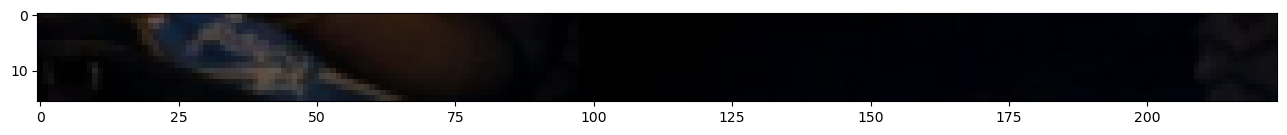

In [13]:
# (C, H, W) -> (H, W, C)
image_permuted = image.permute(1, 2, 0)

# index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

number of patches per row: 14
patch size: 16 pixels x 16 pixels


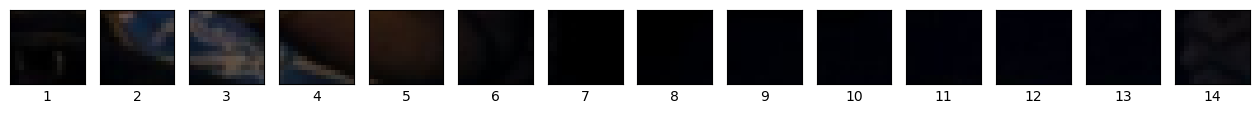

In [14]:
img_size = 224
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size, apply clipping!"
print(f"number of patches per row: {int(num_patches)}\npatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=1,
                        ncols=int(num_patches),
                        figsize=(patch_size, num_patches),
                        sharex=True,
                        sharey=True)
for i, patch in enumerate(torch.arange(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [15]:
# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


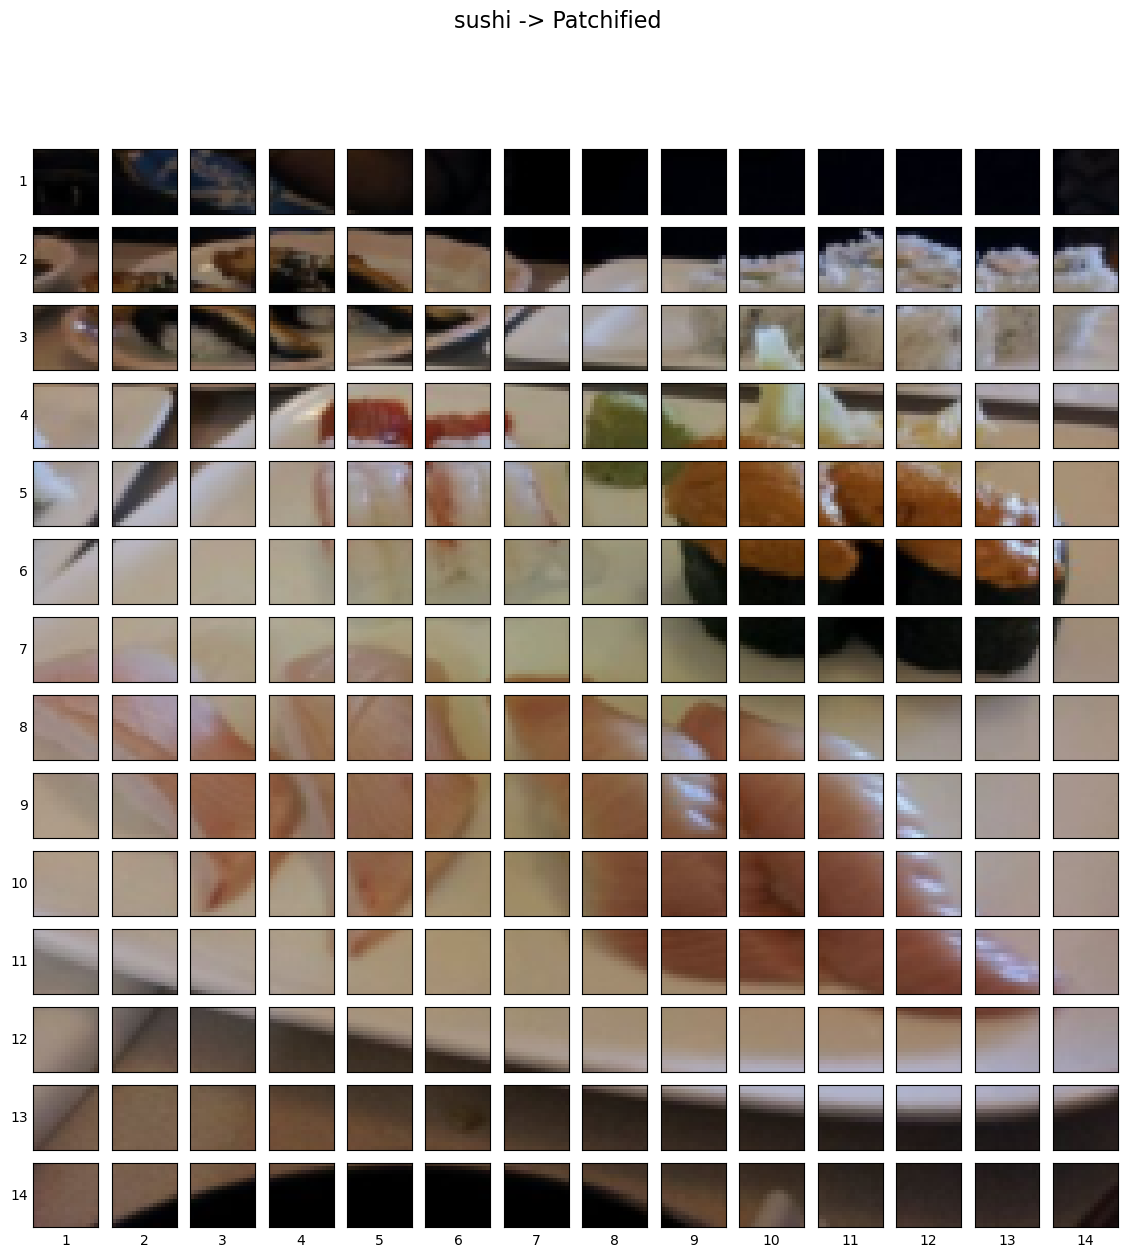

In [16]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=int(num_patches), # need int not float
                        ncols=int(num_patches),
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [20]:
from torch import nn

conv2d = nn.Conv2d(in_channels=3, out_channels=768, kernel_size=patch_size, stride=patch_size, padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

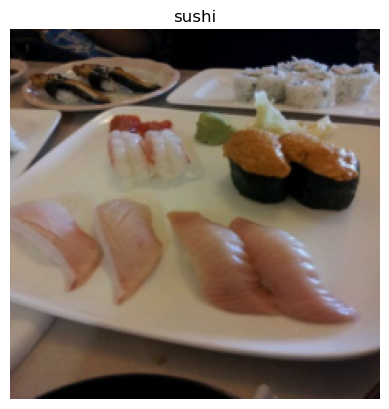

In [17]:
plt.imshow(image_permuted)
plt.title(class_names[label])
plt.axis(False)

In [22]:
# pass the image through the convulutional layer
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)  # batch_dim x D x (14x14: 196 number of patch)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [754, 400, 661, 748, 102]


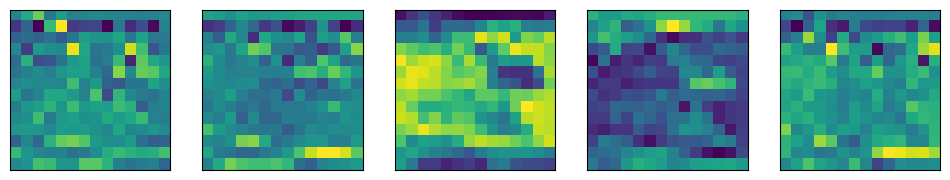

In [26]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [27]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [28]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


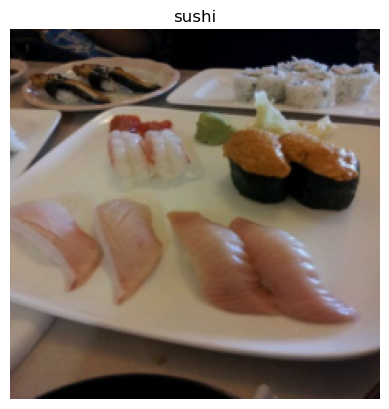

In [29]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [30]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


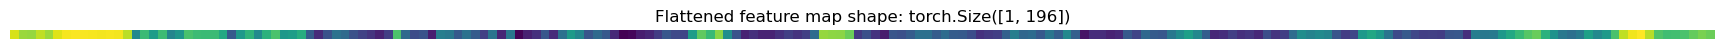

In [31]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [34]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape, single_flattened_feature_map.grad_fn, single_flattened_feature_map.grad

C:\Users\user\AppData\Local\Temp\ipykernel_16380\3180149894.py:2: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten\src\ATen/core/TensorBody.h:494.)
  single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape, single_flattened_feature_map.grad_fn, single_flattened_feature_map.grad


(tensor([[-0.0262, -0.0880, -0.0938, -0.0491, -0.0837, -0.0179,  0.0063,  0.0135,
           0.0084,  0.0070,  0.0054,  0.0055,  0.0031, -0.0548, -0.3516, -0.2031,
          -0.2930, -0.2020, -0.3601, -0.3129, -0.1829, -0.2001, -0.2035, -0.2036,
          -0.2573, -0.4802, -0.3011, -0.2261, -0.3433, -0.2293, -0.1806, -0.3061,
          -0.2903, -0.2444, -0.4743, -0.5891, -0.5017, -0.4155, -0.4371, -0.5045,
          -0.5381, -0.5691, -0.6057, -0.5472, -0.1757, -0.4369, -0.5151, -0.4984,
          -0.6177, -0.3797, -0.3942, -0.4786, -0.4130, -0.4741, -0.5431, -0.4065,
          -0.6021, -0.4014, -0.6686, -0.6110, -0.5793, -0.4878, -0.5888, -0.4172,
          -0.2992, -0.3580, -0.4924, -0.4352, -0.4806, -0.5954, -0.6747, -0.6619,
          -0.6203, -0.6007, -0.5523, -0.4861, -0.5211, -0.5296, -0.2932, -0.1517,
          -0.2099, -0.1074, -0.3294, -0.4973, -0.6076, -0.5792, -0.6066, -0.6067,
          -0.5754, -0.5432, -0.5714, -0.5450, -0.4303, -0.0941, -0.1017, -0.1033,
          -0.138

In [37]:
class PatchEmbedding(nn.Module):
    """
    Turns a 2d input image into a 1d sequence learneble embedding vector.

    Args:
        in_channels (int): number of color channels for the input image. Defaults to 3
        patch_size (int): size of patches to convert input image into. Defaults to 16
        embedding_dim (int): size of embedding to turn image into. Defaults to 768
    """
    # initialize the class with appropriate variables
    def __init__(self, in_channels:int=3, patch_size:int=16, embedding_dim:int=768):
        super().__init__()

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                out_channels=embedding_dim,
                                kernel_size=patch_size,
                                stride=patch_size,
                                padding=0)
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        # create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2C, N] -> [batch_size, N, P^2C]

In [53]:
# set seeds
def set_seeds(seed: int=42):
    """
    Sets random seeds for torch operations.

    Args:
        seed (int, optional): random seed to set. Defaults to 42
    """
    # set the seed for general torch operations
    torch.manual_seed(seed)
    # set the seed for cuda torch operations (ops in gpu)
    torch.cuda.manual_seed(seed)

In [56]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [60]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [61]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [62]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [-4.9798e-02,  7.9654e-04, -5.1562e-02,  ...,  1.9455e-02,
          -4.4014e-03,  5.0198e-03],
         [-1.5103e-01,  5.3823e-02, -4.7642e-03,  ...,  6.1218e-02,
          -7.3259e-02,  3.4995e-02],
         ...,
         [-1.8130e-01,  5.3743e-03, -9.0382e-02,  ...,  1.2600e-01,
          -5.4123e-02,  8.6625e-02],
         [-1.8079e-01,  1.5131e-02, -7.6247e-02,  ...,  1.1533e-01,
          -6.1480e-02,  6.7699e-02],
         [-1.7490e-01,  1.7870e-02, -5.5247e-02,  ...,  1.1253e-01,
          -7.2916e-02,  6.8818e-02]]], grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [63]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
            1.0000e+00,  1.0000e+00],
          [-4.9798e-02,  7.9654e-04, -5.1562e-02,  ...,  1.9455e-02,
           -4.4014e-03,  5.0198e-03],
          [-1.5103e-01,  5.3823e-02, -4.7642e-03,  ...,  6.1218e-02,
           -7.3259e-02,  3.4995e-02],
          ...,
          [-1.8130e-01,  5.3743e-03, -9.0382e-02,  ...,  1.2600e-01,
           -5.4123e-02,  8.6625e-02],
          [-1.8079e-01,  1.5131e-02, -7.6247e-02,  ...,  1.1533e-01,
           -6.1480e-02,  6.7699e-02],
          [-1.7490e-01,  1.7870e-02, -5.5247e-02,  ...,  1.1253e-01,
           -7.2916e-02,  6.8818e-02]]], grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [64]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [65]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9502, 1.0008, 0.9484,  ..., 1.0195, 0.9956, 1.0050],
         [0.8490, 1.0538, 0.9952,  ..., 1.0612, 0.9267, 1.0350],
         ...,
         [0.8187, 1.0054, 0.9096,  ..., 1.1260, 0.9459, 1.0866],
         [0.8192, 1.0151, 0.9238,  ..., 1.1153, 0.9385, 1.0677],
         [0.8251, 1.0179, 0.9448,  ..., 1.1125, 0.9271, 1.0688]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [66]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [67]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [68]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


In [69]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [70]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [71]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [72]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [73]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [76]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])  

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [77]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [78]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [79]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

In [82]:
from MakeModular import engine

optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr= 0.0001, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.0) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

## Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
#optimizer = torch.optim.Adam(params=vit.parameters(),
#                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
#                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
#                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Train || batch number: 0 || current train_loss: 1.1432
Train || batch number: 1 || current train_loss: 1.1344
Train || batch number: 2 || current train_loss: 1.1425
Train || batch number: 3 || current train_loss: 1.1422
Train || batch number: 4 || current train_loss: 1.1193
Train || batch number: 5 || current train_loss: 1.1401
Train || batch number: 6 || current train_loss: 1.1151
Train || batch number: 7 || current train_loss: 1.0966
Train || batch number: 8 || current train_loss: 1.0869
Train || batch number: 9 || current train_loss: 1.1101
Train || batch number: 10 || current train_loss: 1.1262
Train || batch number: 11 || current train_loss: 1.1333
Train || batch number: 12 || current train_loss: 1.1188
Train || batch number: 13 || current train_loss: 1.0831
Train || batch number: 14 || current train_loss: 1.0713
Test || batch number: 0 || current train_loss: 1.0604
Test || batch number: 1 || current train_loss: 1.1024
Test || batch number: 2 || current train_loss: 1.1352
Test || 

 10%|█         | 1/10 [00:12<01:52, 12.48s/it]

Test || batch number: 4 || current train_loss: 1.1015
Epochs: 1 | train_loss: 1.1175 |train_acc: 0.3125 | test_loss: 1.1019 | test_acc: 0.2875
Train || batch number: 0 || current train_loss: 1.0810
Train || batch number: 1 || current train_loss: 1.0851
Train || batch number: 2 || current train_loss: 1.0891
Train || batch number: 3 || current train_loss: 1.0957
Train || batch number: 4 || current train_loss: 1.0699
Train || batch number: 5 || current train_loss: 1.0526
Train || batch number: 6 || current train_loss: 1.1146
Train || batch number: 7 || current train_loss: 1.0995
Train || batch number: 8 || current train_loss: 1.1995
Train || batch number: 9 || current train_loss: 1.1802
Train || batch number: 10 || current train_loss: 1.1306
Train || batch number: 11 || current train_loss: 1.1213
Train || batch number: 12 || current train_loss: 1.0809
Train || batch number: 13 || current train_loss: 1.1278
Train || batch number: 14 || current train_loss: 1.0812
Test || batch number: 0 || 

 20%|██        | 2/10 [00:24<01:38, 12.37s/it]

Test || batch number: 3 || current train_loss: 1.1029
Test || batch number: 4 || current train_loss: 1.0394
Epochs: 2 | train_loss: 1.1073 |train_acc: 0.3604 | test_loss: 1.1161 | test_acc: 0.2875
Train || batch number: 0 || current train_loss: 1.1177
Train || batch number: 1 || current train_loss: 1.0920
Train || batch number: 2 || current train_loss: 1.0948
Train || batch number: 3 || current train_loss: 1.0911
Train || batch number: 4 || current train_loss: 1.0958
Train || batch number: 5 || current train_loss: 1.0819
Train || batch number: 6 || current train_loss: 1.0918
Train || batch number: 7 || current train_loss: 1.1096
Train || batch number: 8 || current train_loss: 1.0979
Train || batch number: 9 || current train_loss: 1.1117
Train || batch number: 10 || current train_loss: 1.1273
Train || batch number: 11 || current train_loss: 1.0943
Train || batch number: 12 || current train_loss: 1.0962
Train || batch number: 13 || current train_loss: 1.0980
Train || batch number: 14 || 

 30%|███       | 3/10 [00:37<01:26, 12.39s/it]

Test || batch number: 4 || current train_loss: 1.1014
Epochs: 3 | train_loss: 1.0988 |train_acc: 0.2938 | test_loss: 1.0935 | test_acc: 0.3625
Train || batch number: 0 || current train_loss: 1.0934
Train || batch number: 1 || current train_loss: 1.0947
Train || batch number: 2 || current train_loss: 1.1052
Train || batch number: 3 || current train_loss: 1.0857
Train || batch number: 4 || current train_loss: 1.0851
Train || batch number: 5 || current train_loss: 1.1075
Train || batch number: 6 || current train_loss: 1.0966
Train || batch number: 7 || current train_loss: 1.1066
Train || batch number: 8 || current train_loss: 1.0792
Train || batch number: 9 || current train_loss: 1.0999
Train || batch number: 10 || current train_loss: 1.0838
Train || batch number: 11 || current train_loss: 1.0687
Train || batch number: 12 || current train_loss: 1.1159
Train || batch number: 13 || current train_loss: 1.1085
Train || batch number: 14 || current train_loss: 1.0533
Test || batch number: 0 || 

 40%|████      | 4/10 [00:49<01:14, 12.46s/it]

Epochs: 4 | train_loss: 1.0923 |train_acc: 0.3563 | test_loss: 1.1078 | test_acc: 0.2875
Train || batch number: 0 || current train_loss: 1.1366
Train || batch number: 1 || current train_loss: 1.0616
Train || batch number: 2 || current train_loss: 1.0533
Train || batch number: 3 || current train_loss: 1.1372
Train || batch number: 4 || current train_loss: 1.1545
Train || batch number: 5 || current train_loss: 1.0448
Train || batch number: 6 || current train_loss: 1.0871
Train || batch number: 7 || current train_loss: 1.0841
Train || batch number: 8 || current train_loss: 1.0915
Train || batch number: 9 || current train_loss: 1.0981
Train || batch number: 10 || current train_loss: 1.0753
Train || batch number: 11 || current train_loss: 1.0970
Train || batch number: 12 || current train_loss: 1.0942
Train || batch number: 13 || current train_loss: 1.1089
Train || batch number: 14 || current train_loss: 1.0121
Test || batch number: 0 || current train_loss: 0.8981
Test || batch number: 1 || 

 50%|█████     | 5/10 [01:02<01:01, 12.39s/it]

Test || batch number: 4 || current train_loss: 1.0192
Epochs: 5 | train_loss: 1.0891 |train_acc: 0.4042 | test_loss: 1.0849 | test_acc: 0.4489
Train || batch number: 0 || current train_loss: 1.0668
Train || batch number: 1 || current train_loss: 1.0587
Train || batch number: 2 || current train_loss: 1.0746
Train || batch number: 3 || current train_loss: 1.0936
Train || batch number: 4 || current train_loss: 1.2052
Train || batch number: 5 || current train_loss: 1.1022
Train || batch number: 6 || current train_loss: 1.0496
Train || batch number: 7 || current train_loss: 1.0857
Train || batch number: 8 || current train_loss: 1.0679
Train || batch number: 9 || current train_loss: 1.0548
Train || batch number: 10 || current train_loss: 1.1442
Train || batch number: 11 || current train_loss: 1.0361
Train || batch number: 12 || current train_loss: 1.0962
Train || batch number: 13 || current train_loss: 1.0676
Train || batch number: 14 || current train_loss: 0.9794
Test || batch number: 0 || 

 60%|██████    | 6/10 [01:14<00:49, 12.36s/it]

Test || batch number: 4 || current train_loss: 0.9541
Epochs: 6 | train_loss: 1.0788 |train_acc: 0.4042 | test_loss: 1.0504 | test_acc: 0.3812
Train || batch number: 0 || current train_loss: 1.0569
Train || batch number: 1 || current train_loss: 1.1558
Train || batch number: 2 || current train_loss: 1.2577
Train || batch number: 3 || current train_loss: 1.0112
Train || batch number: 4 || current train_loss: 1.0706
Train || batch number: 5 || current train_loss: 1.0671
Train || batch number: 6 || current train_loss: 1.0742
Train || batch number: 7 || current train_loss: 1.0568
Train || batch number: 8 || current train_loss: 1.0989
Train || batch number: 9 || current train_loss: 1.0597
Train || batch number: 10 || current train_loss: 1.0656
Train || batch number: 11 || current train_loss: 1.0562
Train || batch number: 12 || current train_loss: 1.0846
Train || batch number: 13 || current train_loss: 1.0356
Train || batch number: 14 || current train_loss: 0.5804
Test || batch number: 0 || 

 70%|███████   | 7/10 [01:26<00:36, 12.32s/it]

Test || batch number: 4 || current train_loss: 1.2592
Epochs: 7 | train_loss: 1.0488 |train_acc: 0.4500 | test_loss: 1.1349 | test_acc: 0.3330
Train || batch number: 0 || current train_loss: 1.0444
Train || batch number: 1 || current train_loss: 1.1499
Train || batch number: 2 || current train_loss: 1.2358
Train || batch number: 3 || current train_loss: 1.0646
Train || batch number: 4 || current train_loss: 0.9342
Train || batch number: 5 || current train_loss: 1.0508
Train || batch number: 6 || current train_loss: 1.0692
Train || batch number: 7 || current train_loss: 1.0217
Train || batch number: 8 || current train_loss: 1.0201
Train || batch number: 9 || current train_loss: 1.2010
Train || batch number: 10 || current train_loss: 1.0114
Train || batch number: 11 || current train_loss: 1.0537
Train || batch number: 12 || current train_loss: 1.0348
Train || batch number: 13 || current train_loss: 1.1168
Train || batch number: 14 || current train_loss: 0.9051
Test || batch number: 0 || 

 80%|████████  | 8/10 [01:38<00:24, 12.30s/it]

Epochs: 8 | train_loss: 1.0609 |train_acc: 0.4771 | test_loss: 1.0471 | test_acc: 0.4437
Train || batch number: 0 || current train_loss: 1.0756
Train || batch number: 1 || current train_loss: 1.0331
Train || batch number: 2 || current train_loss: 1.1372
Train || batch number: 3 || current train_loss: 1.0712
Train || batch number: 4 || current train_loss: 1.0482
Train || batch number: 5 || current train_loss: 1.0545
Train || batch number: 6 || current train_loss: 1.0187
Train || batch number: 7 || current train_loss: 1.0490
Train || batch number: 8 || current train_loss: 1.0758
Train || batch number: 9 || current train_loss: 1.0414
Train || batch number: 10 || current train_loss: 1.0268
Train || batch number: 11 || current train_loss: 1.0411
Train || batch number: 12 || current train_loss: 1.0639
Train || batch number: 13 || current train_loss: 1.0074
Train || batch number: 14 || current train_loss: 0.7042
Test || batch number: 0 || current train_loss: 0.5477
Test || batch number: 1 || 

 90%|█████████ | 9/10 [01:51<00:12, 12.29s/it]

Test || batch number: 3 || current train_loss: 1.3044
Test || batch number: 4 || current train_loss: 1.1608
Epochs: 9 | train_loss: 1.0299 |train_acc: 0.4771 | test_loss: 1.0915 | test_acc: 0.3625
Train || batch number: 0 || current train_loss: 1.0129
Train || batch number: 1 || current train_loss: 1.0456
Train || batch number: 2 || current train_loss: 0.9740
Train || batch number: 3 || current train_loss: 1.1978
Train || batch number: 4 || current train_loss: 0.9350
Train || batch number: 5 || current train_loss: 1.0096
Train || batch number: 6 || current train_loss: 1.0208
Train || batch number: 7 || current train_loss: 1.0660
Train || batch number: 8 || current train_loss: 1.2147
Train || batch number: 9 || current train_loss: 1.1808
Train || batch number: 10 || current train_loss: 1.1275
Train || batch number: 11 || current train_loss: 1.0041
Train || batch number: 12 || current train_loss: 1.0912
Train || batch number: 13 || current train_loss: 0.9808
Train || batch number: 14 || 

100%|██████████| 10/10 [02:03<00:00, 12.34s/it]

Test || batch number: 4 || current train_loss: 0.9867
Epochs: 10 | train_loss: 1.0592 |train_acc: 0.4500 | test_loss: 0.9828 | test_acc: 0.5716


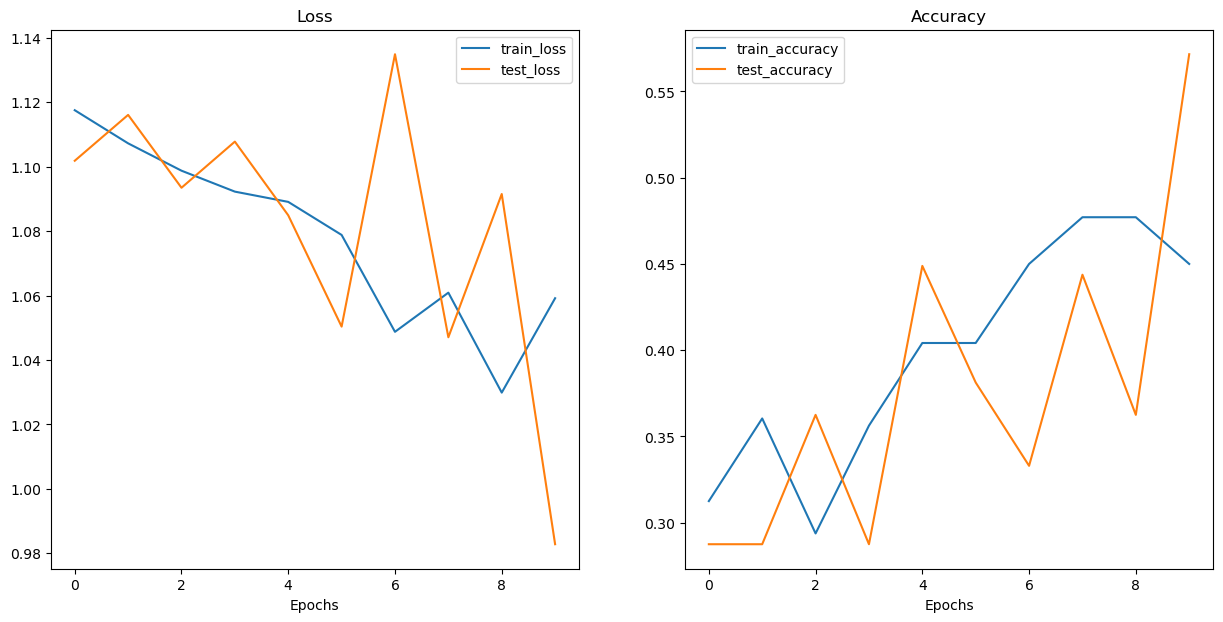

In [83]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

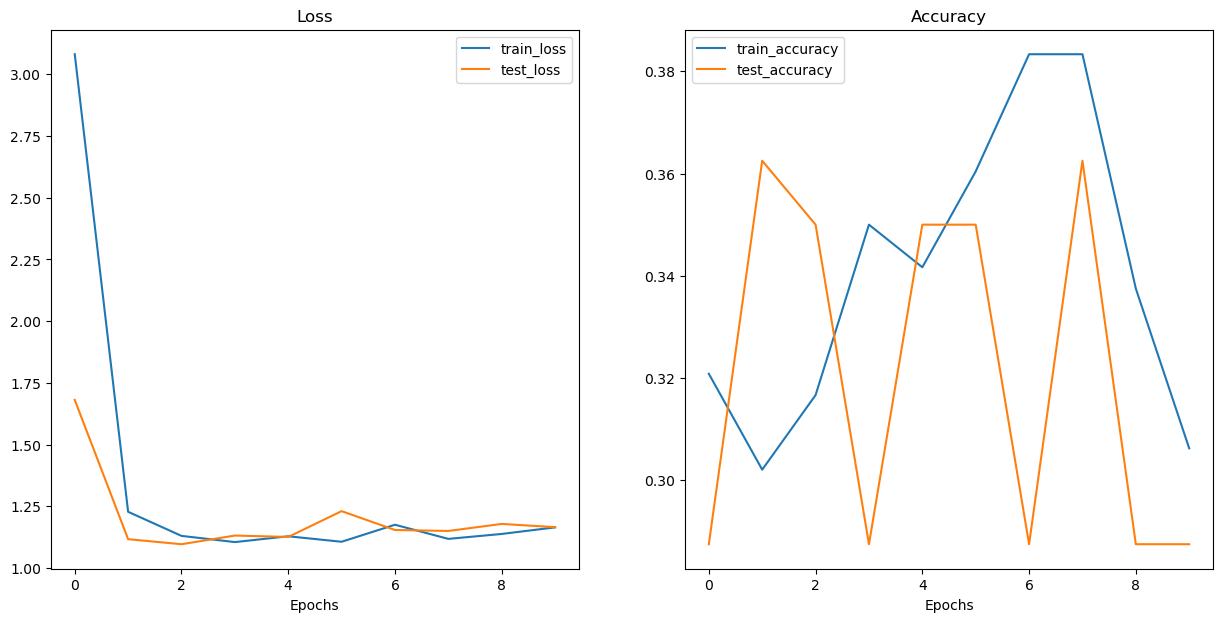

In [81]:
#from helper_functions import plot_loss_curves
#
## Plot our ViT model's loss curves
#plot_loss_curves(results)

In [84]:
# The following requires torch v0.12+ and torchvision v0.13+
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.1.2+cu121
0.16.2+cu121


In [85]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [86]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to C:\Users\user/.cache\torch\hub\checkpoints\vit_b_16-c867db91.pth
100%|██████████| 330M/330M [02:17<00:00, 2.51MB/s] 


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [87]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [88]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [90]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [92]:
from MakeModular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Train || batch number: 0 || current train_loss: 1.2028
Train || batch number: 1 || current train_loss: 1.0327
Train || batch number: 2 || current train_loss: 0.8526
Train || batch number: 3 || current train_loss: 0.7731
Train || batch number: 4 || current train_loss: 0.7687
Train || batch number: 5 || current train_loss: 0.5407
Train || batch number: 6 || current train_loss: 0.6268
Train || batch number: 7 || current train_loss: 0.6164
Train || batch number: 8 || current train_loss: 0.4377
Train || batch number: 9 || current train_loss: 0.4685
Train || batch number: 10 || current train_loss: 0.3800
Train || batch number: 11 || current train_loss: 0.4255
Train || batch number: 12 || current train_loss: 0.3833
Train || batch number: 13 || current train_loss: 0.3895
Train || batch number: 14 || current train_loss: 1.6368
Test || batch number: 0 || current train_loss: 0.0639
Test || batch number: 1 || current train_loss: 0.1987
Test || batch number: 2 || current train_loss: 0.3429
Test || 

 10%|█         | 1/10 [00:08<01:15,  8.44s/it]

Test || batch number: 4 || current train_loss: 0.4165
Epochs: 1 | train_loss: 0.7023 |train_acc: 0.7500 | test_loss: 0.2714 | test_acc: 0.9290
Train || batch number: 0 || current train_loss: 0.3000
Train || batch number: 1 || current train_loss: 0.2444
Train || batch number: 2 || current train_loss: 0.2637
Train || batch number: 3 || current train_loss: 0.2231
Train || batch number: 4 || current train_loss: 0.1833
Train || batch number: 5 || current train_loss: 0.1841
Train || batch number: 6 || current train_loss: 0.2540
Train || batch number: 7 || current train_loss: 0.2228
Train || batch number: 8 || current train_loss: 0.2026
Train || batch number: 9 || current train_loss: 0.2665
Train || batch number: 10 || current train_loss: 0.1864
Train || batch number: 11 || current train_loss: 0.2765
Train || batch number: 12 || current train_loss: 0.1251
Train || batch number: 13 || current train_loss: 0.2830
Train || batch number: 14 || current train_loss: 0.5810
Test || batch number: 0 || 

 20%|██        | 2/10 [00:16<01:04,  8.09s/it]

Test || batch number: 4 || current train_loss: 0.3094
Epochs: 2 | train_loss: 0.2531 |train_acc: 0.9104 | test_loss: 0.1669 | test_acc: 0.9602
Train || batch number: 0 || current train_loss: 0.1522
Train || batch number: 1 || current train_loss: 0.1378
Train || batch number: 2 || current train_loss: 0.1499
Train || batch number: 3 || current train_loss: 0.2608
Train || batch number: 4 || current train_loss: 0.0927
Train || batch number: 5 || current train_loss: 0.0733
Train || batch number: 6 || current train_loss: 0.2030
Train || batch number: 7 || current train_loss: 0.2621
Train || batch number: 8 || current train_loss: 0.1004
Train || batch number: 9 || current train_loss: 0.2038
Train || batch number: 10 || current train_loss: 0.1872
Train || batch number: 11 || current train_loss: 0.2569
Train || batch number: 12 || current train_loss: 0.1270
Train || batch number: 13 || current train_loss: 0.0883
Train || batch number: 14 || current train_loss: 0.3530
Test || batch number: 0 || 

 30%|███       | 3/10 [00:24<00:56,  8.05s/it]

Test || batch number: 4 || current train_loss: 0.2372
Epochs: 3 | train_loss: 0.1766 |train_acc: 0.9542 | test_loss: 0.1270 | test_acc: 0.9693
Train || batch number: 0 || current train_loss: 0.0672
Train || batch number: 1 || current train_loss: 0.1520
Train || batch number: 2 || current train_loss: 0.2089
Train || batch number: 3 || current train_loss: 0.1968
Train || batch number: 4 || current train_loss: 0.1113
Train || batch number: 5 || current train_loss: 0.2194
Train || batch number: 6 || current train_loss: 0.0790
Train || batch number: 7 || current train_loss: 0.1172
Train || batch number: 8 || current train_loss: 0.1704
Train || batch number: 9 || current train_loss: 0.0892
Train || batch number: 10 || current train_loss: 0.1104
Train || batch number: 11 || current train_loss: 0.0769
Train || batch number: 12 || current train_loss: 0.0735
Train || batch number: 13 || current train_loss: 0.2330
Train || batch number: 14 || current train_loss: 0.0108
Test || batch number: 0 || 

 40%|████      | 4/10 [00:32<00:47,  7.97s/it]

Test || batch number: 4 || current train_loss: 0.1833
Epochs: 4 | train_loss: 0.1277 |train_acc: 0.9625 | test_loss: 0.1072 | test_acc: 0.9722
Train || batch number: 0 || current train_loss: 0.1225
Train || batch number: 1 || current train_loss: 0.0830
Train || batch number: 2 || current train_loss: 0.1004
Train || batch number: 3 || current train_loss: 0.0625
Train || batch number: 4 || current train_loss: 0.1398
Train || batch number: 5 || current train_loss: 0.1787
Train || batch number: 6 || current train_loss: 0.1807
Train || batch number: 7 || current train_loss: 0.1301
Train || batch number: 8 || current train_loss: 0.0695
Train || batch number: 9 || current train_loss: 0.1992
Train || batch number: 10 || current train_loss: 0.0539
Train || batch number: 11 || current train_loss: 0.1447
Train || batch number: 12 || current train_loss: 0.0804
Train || batch number: 13 || current train_loss: 0.0958
Train || batch number: 14 || current train_loss: 0.1025
Test || batch number: 0 || 

 50%|█████     | 5/10 [00:40<00:39,  7.94s/it]

Test || batch number: 4 || current train_loss: 0.1669
Epochs: 5 | train_loss: 0.1163 |train_acc: 0.9646 | test_loss: 0.0950 | test_acc: 0.9784
Train || batch number: 0 || current train_loss: 0.0818
Train || batch number: 1 || current train_loss: 0.1093
Train || batch number: 2 || current train_loss: 0.0792
Train || batch number: 3 || current train_loss: 0.1553
Train || batch number: 4 || current train_loss: 0.0359
Train || batch number: 5 || current train_loss: 0.1099
Train || batch number: 6 || current train_loss: 0.0348
Train || batch number: 7 || current train_loss: 0.1580
Train || batch number: 8 || current train_loss: 0.0787
Train || batch number: 9 || current train_loss: 0.1045
Train || batch number: 10 || current train_loss: 0.1433
Train || batch number: 11 || current train_loss: 0.1450
Train || batch number: 12 || current train_loss: 0.0790
Train || batch number: 13 || current train_loss: 0.0878
Train || batch number: 14 || current train_loss: 0.5030
Test || batch number: 0 || 

 60%|██████    | 6/10 [00:47<00:31,  7.91s/it]

Test || batch number: 4 || current train_loss: 0.1230
Epochs: 6 | train_loss: 0.1270 |train_acc: 0.9375 | test_loss: 0.0830 | test_acc: 0.9722
Train || batch number: 0 || current train_loss: 0.0405
Train || batch number: 1 || current train_loss: 0.0643
Train || batch number: 2 || current train_loss: 0.0826
Train || batch number: 3 || current train_loss: 0.0907
Train || batch number: 4 || current train_loss: 0.1417
Train || batch number: 5 || current train_loss: 0.0691
Train || batch number: 6 || current train_loss: 0.1001
Train || batch number: 7 || current train_loss: 0.0637
Train || batch number: 8 || current train_loss: 0.0971
Train || batch number: 9 || current train_loss: 0.0626
Train || batch number: 10 || current train_loss: 0.2293
Train || batch number: 11 || current train_loss: 0.0960
Train || batch number: 12 || current train_loss: 0.0472
Train || batch number: 13 || current train_loss: 0.1593
Train || batch number: 14 || current train_loss: 0.0044
Test || batch number: 0 || 

 70%|███████   | 7/10 [00:55<00:23,  7.90s/it]

Test || batch number: 4 || current train_loss: 0.0971
Epochs: 7 | train_loss: 0.0899 |train_acc: 0.9771 | test_loss: 0.0844 | test_acc: 0.9784
Train || batch number: 0 || current train_loss: 0.0979
Train || batch number: 1 || current train_loss: 0.0506
Train || batch number: 2 || current train_loss: 0.0570
Train || batch number: 3 || current train_loss: 0.0410
Train || batch number: 4 || current train_loss: 0.1480
Train || batch number: 5 || current train_loss: 0.0611
Train || batch number: 6 || current train_loss: 0.0704
Train || batch number: 7 || current train_loss: 0.0406
Train || batch number: 8 || current train_loss: 0.0681
Train || batch number: 9 || current train_loss: 0.0727
Train || batch number: 10 || current train_loss: 0.1128
Train || batch number: 11 || current train_loss: 0.0824
Train || batch number: 12 || current train_loss: 0.0820
Train || batch number: 13 || current train_loss: 0.1435
Train || batch number: 14 || current train_loss: 0.2633
Test || batch number: 0 || 

 80%|████████  | 8/10 [01:03<00:15,  7.89s/it]

Test || batch number: 4 || current train_loss: 0.1238
Epochs: 8 | train_loss: 0.0928 |train_acc: 0.9812 | test_loss: 0.0759 | test_acc: 0.9722
Train || batch number: 0 || current train_loss: 0.0486
Train || batch number: 1 || current train_loss: 0.0856
Train || batch number: 2 || current train_loss: 0.0758
Train || batch number: 3 || current train_loss: 0.0743
Train || batch number: 4 || current train_loss: 0.0357
Train || batch number: 5 || current train_loss: 0.0629
Train || batch number: 6 || current train_loss: 0.0470
Train || batch number: 7 || current train_loss: 0.1477
Train || batch number: 8 || current train_loss: 0.0240
Train || batch number: 9 || current train_loss: 0.1282
Train || batch number: 10 || current train_loss: 0.0612
Train || batch number: 11 || current train_loss: 0.0376
Train || batch number: 12 || current train_loss: 0.1194
Train || batch number: 13 || current train_loss: 0.0778
Train || batch number: 14 || current train_loss: 0.3740
Test || batch number: 0 || 

 90%|█████████ | 9/10 [01:11<00:07,  7.91s/it]

Test || batch number: 4 || current train_loss: 0.1355
Epochs: 9 | train_loss: 0.0933 |train_acc: 0.9792 | test_loss: 0.0729 | test_acc: 0.9784
Train || batch number: 0 || current train_loss: 0.0403
Train || batch number: 1 || current train_loss: 0.0424
Train || batch number: 2 || current train_loss: 0.0393
Train || batch number: 3 || current train_loss: 0.0645
Train || batch number: 4 || current train_loss: 0.0567
Train || batch number: 5 || current train_loss: 0.0950
Train || batch number: 6 || current train_loss: 0.1029
Train || batch number: 7 || current train_loss: 0.0751
Train || batch number: 8 || current train_loss: 0.0442
Train || batch number: 9 || current train_loss: 0.1083
Train || batch number: 10 || current train_loss: 0.0445
Train || batch number: 11 || current train_loss: 0.1060
Train || batch number: 12 || current train_loss: 0.0704
Train || batch number: 13 || current train_loss: 0.0137
Train || batch number: 14 || current train_loss: 0.0893
Test || batch number: 0 || 

100%|██████████| 10/10 [01:19<00:00,  7.94s/it]

Test || batch number: 4 || current train_loss: 0.0857
Epochs: 10 | train_loss: 0.0662 |train_acc: 0.9833 | test_loss: 0.0642 | test_acc: 0.9847


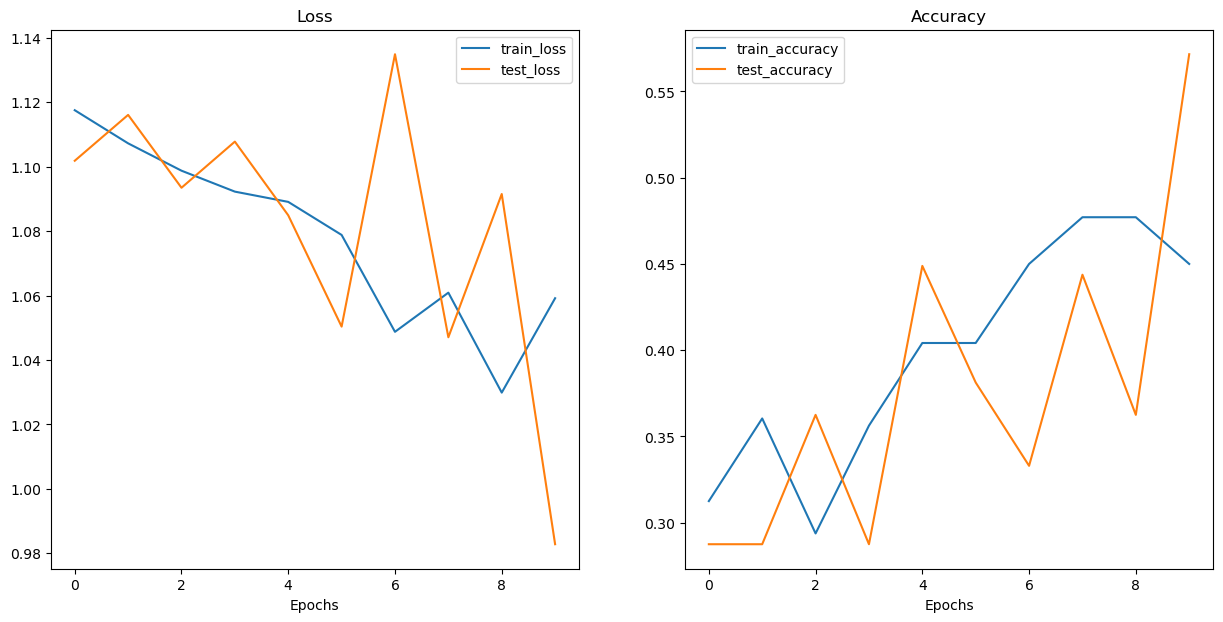

In [93]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

In [94]:
# Save the model
from MakeModular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models\08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [95]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


# ÇAPA

In [68]:
whos

Variable                      Type                          Data/Info
---------------------------------------------------------------------
BATCH_SIZE                    int                           32
OUT_FEATURES                  int                           3
Path                          type                          <class 'pathlib.Path'>
SummaryWriter                 type                          <class 'torch.utils.tenso<...>rd.writer.SummaryWriter'>
auto_transforms               ImageClassification           ImageClassification(\n   <...>erpolationMode.BICUBIC\n)
best_model                    EfficientNet                  EfficientNet(\n  (feature<...>res=3, bias=True)\n  )\n)
best_model_path               str                           models/experiment_8_effne<...>_20_percent_10_epochs.pth
class_names                   list                          n=3
create_effnetb0               function                      <function create_effnetb0 at 0x000001C241D7B2E0>
create_effnetb2

In [69]:
datetime.now().strftime("%Y-%m-%d__%H_%M") # returns current date in YYYY-MM-DD format

NameError: name 'datetime' is not defined

# Autograd

In [8]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
print(z.requires_grad)

True


In [11]:
z = torch.matmul(x, w)+b
print(z.requires_grad)
#z.retain_grad()

z.backward(torch.ones_like(z))

True


In [12]:
print(w.requires_grad)
with torch.inference_mode():
    z = torch.matmul(x, w)+b
    print(w.grad_fn)
    print(w.grad)
    print(w.requires_grad)
print(w.grad_fn)
print(w.grad)
print(w.requires_grad)

True
None
tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]])
True
None
tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]])
True


In [ ]:
z = torch.matmul(x, w)+b
print(z.requires_grad)
z.retain_grad() 
z.backward(torch.ones_like(z))

In [ ]:
x.grad, y.grad, w.grad, b.grad, z.grad

In [ ]:
z = torch.matmul(x, w)+b
print(z.requires_grad)
z_det = z.detach()
print(z_det.requires_grad)
print(z.requires_grad)